In [1]:
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Data.IUPACData import protein_letters_3to1
from Bio.SeqUtils import seq1
import re
import matplotlib.pyplot as plt
import squarify
from functools import reduce
from matplotlib_venn import venn2
import matplotlib_venn as mv

## Cargo los datasets

In [2]:
#Box1 database
box = pd.read_csv('box1_proteins.csv')
box

,uniprot,organism,mlo,hgnc_id,length,sequence
0,O15527,Homo sapiens,nuclear speckle,HGNC:8125,345,MPARALLPRRMGHRTLASTPALWASIPCPRSELRLDLVLPSGQSFR...
1,O43663,Homo sapiens,pcg body,HGNC:9341,620,MRRSEVLAEESIVCLQKALNHLREIWELIGIPEDQRLQRTEVVKKH...
2,O75494,Homo sapiens,nuclear speckle,HGNC:16713,262,MSRYLRPPNTSLFVRNVADDTRSEDLRREFGRYGPIVDVYVPLDFY...
3,O95613,Homo sapiens,centrosome/spindle pole body,HGNC:16068,3336,MEVEQEQRRRKVEAGRTKLAHFRQRKTKGDSSHSEKKTAKRKGSAV...
4,P08047,Homo sapiens,centrosome/spindle pole body,HGNC:11205,785,MSDQDHSMDEMTAVVKIEKGVGGNNGGNGNGGGAFSQARSSSTGSS...
...,...,...,...,...,...,...
584,Q07352,Homo sapiens,cytoplasmic ribonucleoprotein granule,HGNC:1107,338,MTTTLVSATIFDLSEVLCKGNKMLNYSAPSAGGCLLDRKAVGTPAG...
585,Q8NE35,Homo sapiens,p-body,HGNC:21746,698,MQDDLLMDKSKTQPQPQQQQRQQQQPQPESSVSEAPSTPLSSETPK...
586,P26368,Homo sapiens,nuclear speckle,HGNC:23156,475,MSDFDEFERQLNENKQERDKENRHRKRSHSRSRSRDRKRRSRSRDR...
587,Q15233,Homo sapiens,paraspeckle,HGNC:7871,471,MQSNKTFNLEKQNHTPRKHHQHHHQQQHHQQQQQQPPPPPIPANGQ...


## Dominios: PFAM, LC and IDR

In [97]:
#Dominios PFAM
pfam_box = pd.read_csv('pfam_box1.csv')
pfam_box = pfam_box.rename(columns={'pfam_acc': 'pfam_id', 'domain':'pfam_domain','start':'pfam_start', 'end':'pfam_end'})
#LC zones
lc_box = pd.read_csv('lc_zones_box1.csv')
lc_box = lc_box.rename(columns={'start': 'lc_start', 'end':'lc_end', 'seq':'lc_seq', 'largo':'lc_length'})
#Regiones desordenadas
idr_box = pd.read_csv('idrs_box1_mobidb.csv')
idr_box = idr_box.rename(columns={'tipo':'idr_tipo', 'start':'idr_start', 'end':'idr_end'})


## ClinVar database

In [3]:
#A tab-delimited report based on each variant at a location on the genome for which data have been submitted to ClinVar

clinvar = pd.read_csv('variant_summary.txt', sep= '\t')
clinvar.columns = clinvar.columns.str.lower().str.replace(' ',"_").str.replace("-",'_').str.replace('/','_')
clinvar = clinvar.rename(columns={'#alleleid' : 'alleleid', 'rs#_(dbsnp)': 'snpid', 'origin':'allelic_origins', 'originsimple':'origin'})

#me quedo solo con las entradas del GRCh38
clinvar = clinvar[clinvar.assembly == 'GRCh38']
clinvar.head()

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,alleleid,type,name,geneid,genesymbol,hgnc_id,clinicalsignificance,clinsigsimple,lastevaluated,snpid,...,reviewstatus,numbersubmitters,guidelines,testedingtr,otherids,submittercategories,variationid,positionvcf,referenceallelevcf,alternateallelevcf
1,15041,Indel,NM_014855.3(AP5Z1):c.80_83delinsTGCTGTAAACTGTA...,9907,AP5Z1,HGNC:22197,Pathogenic,1,"Jun 29, 2010",397704705,...,no assertion criteria provided,1,-,N,"ClinGen:CA215070,OMIM:613653.0001",1.0,2,4781213,GGAT,TGCTGTAAACTGTAACTGTAAA
3,15042,Deletion,NM_014855.3(AP5Z1):c.1413_1426del (p.Leu473fs),9907,AP5Z1,HGNC:22197,Pathogenic,1,"Jun 29, 2010",397704709,...,no assertion criteria provided,1,-,N,"ClinGen:CA215072,OMIM:613653.0002",1.0,3,4787729,GCTGCTGGACCTGCC,G
5,15043,single nucleotide variant,NM_014630.3(ZNF592):c.3136G>A (p.Gly1046Arg),9640,ZNF592,HGNC:28986,Uncertain significance,0,"Jun 29, 2015",150829393,...,no assertion criteria provided,1,-,N,"ClinGen:CA210674,UniProtKB:Q92610#VAR_064583,O...",1.0,4,84799209,G,A
7,15044,single nucleotide variant,NM_017547.4(FOXRED1):c.694C>T (p.Gln232Ter),55572,FOXRED1,HGNC:26927,Pathogenic,1,"Dec 30, 2019",267606829,...,"criteria provided, multiple submitters, no con...",3,-,N,"ClinGen:CA113792,OMIM:613622.0001",3.0,5,126275389,C,T
9,15045,single nucleotide variant,NM_017547.4(FOXRED1):c.1289A>G (p.Asn430Ser),55572,FOXRED1,HGNC:26927,Pathogenic,1,"Oct 01, 2010",267606830,...,no assertion criteria provided,1,-,N,"ClinGen:CA113794,UniProtKB:Q96CU9#VAR_064571,O...",1.0,6,126277517,A,G


In [100]:
clinvar.columns

Index(['alleleid', 'type', 'name', 'geneid', 'genesymbol', 'hgnc_id',
       'clinicalsignificance', 'clinsigsimple', 'lastevaluated', 'snpid',
       'nsv_esv_(dbvar)', 'rcvaccession', 'phenotypeids', 'phenotypelist',
       'allelic_origins', 'origin', 'assembly', 'chromosomeaccession',
       'chromosome', 'start', 'stop', 'referenceallele', 'alternateallele',
       'cytogenetic', 'reviewstatus', 'numbersubmitters', 'guidelines',
       'testedingtr', 'otherids', 'submittercategories', 'variationid',
       'positionvcf', 'referenceallelevcf', 'alternateallelevcf'],
      dtype='object')

In [101]:
clinvar[['allelic_origins', 'origin', 'phenotypeids', 'phenotypelist','otherids','variationid']]

,allelic_origins,origin,phenotypeids,phenotypelist,otherids,variationid
1,germline,germline,"MONDO:MONDO:0013342,MedGen:C3150901,OMIM:61364...","Spastic paraplegia 48, autosomal recessive","ClinGen:CA215070,OMIM:613653.0001",2
3,germline,germline,"MONDO:MONDO:0013342,MedGen:C3150901,OMIM:61364...","Spastic paraplegia 48, autosomal recessive","ClinGen:CA215072,OMIM:613653.0002",3
5,germline,germline,"MONDO:MONDO:0033005,MedGen:C4551772,OMIM:25130...",Galloway-Mowat syndrome 1,"ClinGen:CA210674,UniProtKB:Q92610#VAR_064583,O...",4
7,germline,germline,"MONDO:MONDO:0032624,MedGen:C4748791,OMIM:61824...","Mitochondrial complex 1 deficiency, nuclear ty...","ClinGen:CA113792,OMIM:613622.0001",5
9,germline,germline,"MONDO:MONDO:0032624,MedGen:C4748791,OMIM:618241","Mitochondrial complex 1 deficiency, nuclear ty...","ClinGen:CA113794,UniProtKB:Q96CU9#VAR_064571,O...",6
...,...,...,...,...,...,...
1646115,inherited,germline,"MONDO:MONDO:0020716,MedGen:C1848805,OMIM:27440...",Thyroid dyshormonogenesis 1,-,983276
1646117,inherited,germline,"MONDO:MONDO:0020716,MedGen:C1848805,OMIM:27440...",Thyroid dyshormonogenesis 1,-,983277
1646119,de novo,germline,"Human Phenotype Ontology:HP:0000730,Human Phen...",Intellectual disability,-,983278
1646124,germline,germline,MedGen:CN517202,not provided,-,983282


In [102]:
#snpid reported as -1 if missing
clinvar[clinvar.snpid == -1]

,alleleid,type,name,geneid,genesymbol,hgnc_id,clinicalsignificance,clinsigsimple,lastevaluated,snpid,...,reviewstatus,numbersubmitters,guidelines,testedingtr,otherids,submittercategories,variationid,positionvcf,referenceallelevcf,alternateallelevcf
13,15047,Deletion,NC_000014.9:g.(31394019_31414809)_(31654321_31...,80224,NUBPL,HGNC:20278,Pathogenic,1,"Feb 01, 2012",-1,...,no assertion criteria provided,1,-,N,"dbVar:nssv7487142,OMIM:613621.0002",1.0,8,-1,na,na
47,15064,Indel,NM_015600.4(ABHD12):c.-6898_191+7002delinsCC,26090,ABHD12,HGNC:15868,Pathogenic,1,"Sep 10, 2010",-1,...,no assertion criteria provided,1,-,N,"dbVar:nssv3761628,OMIM:613599.0002",1.0,25,-1,na,na
61,15071,single nucleotide variant,NM_138413.4(HOGA1):c.700+4G>T,112817,HOGA1,HGNC:25155,Pathogenic,1,"Sep 10, 2010",-1,...,no assertion criteria provided,1,-,N,"LOVD 3:HOGA1_000005,OMIM:613597.0004",1.0,32,97600167,G,T
337,15213,Deletion,NC_000010.11:g.(124404664_124404669)_(12440473...,4942,OAT,HGNC:8091,Pathogenic,1,"Jun 25, 1992",-1,...,no assertion criteria provided,1,-,N,"dbVar:nssv7487163,OMIM:613349.0031",1.0,174,-1,na,na
406,15248,Deletion,NM_000285.3(PEPD):c.1153_1344del (p.Gly385_Gly...,5184,PEPD,HGNC:8840,Pathogenic,1,"Apr 01, 1991",-1,...,no assertion criteria provided,1,-,N,"dbVar:nssv7487199,OMIM:613230.0002",1.0,209,-1,na,na
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1646115,971345,Deletion,NM_000453.3(SLC5A5):c.152del (p.Gly51fs),6528,SLC5A5,HGNC:11040,Pathogenic,1,"May 12, 2020",-1,...,no assertion criteria provided,1,-,N,-,2.0,983276,17872466,CG,C
1646117,971346,single nucleotide variant,NM_000453.3(SLC5A5):c.1261G>A (p.Gly421Arg),6528,SLC5A5,HGNC:11040,Pathogenic,1,"May 12, 2020",-1,...,no assertion criteria provided,1,-,N,-,2.0,983277,17883699,G,A
1646119,971347,single nucleotide variant,NM_020699.4(GATAD2B):c.1417C>T (p.Gln473Ter),57459,GATAD2B,HGNC:30778,Pathogenic,1,"Oct 30, 2020",-1,...,"criteria provided, single submitter",1,-,N,-,2.0,983278,153813252,G,A
1646124,971351,single nucleotide variant,NM_000051.4(ATM):c.*8T>G,472,ATM,HGNC:795,Likely benign,0,"Jul 07, 2017",-1,...,"criteria provided, single submitter",1,-,N,-,2.0,983282,108365516,T,G


In [4]:
#Subset del df de ClinVar: vs
vs = clinvar[['geneid', 'genesymbol', 'hgnc_id', 'snpid', 'alleleid', 'type', 'name', 'origin', 'phenotypeids', 'phenotypelist', 'otherids']]
vs.head()

,geneid,genesymbol,hgnc_id,snpid,alleleid,type,name,origin,phenotypeids,phenotypelist,otherids
1,9907,AP5Z1,HGNC:22197,397704705,15041,Indel,NM_014855.3(AP5Z1):c.80_83delinsTGCTGTAAACTGTA...,germline,"MONDO:MONDO:0013342,MedGen:C3150901,OMIM:61364...","Spastic paraplegia 48, autosomal recessive","ClinGen:CA215070,OMIM:613653.0001"
3,9907,AP5Z1,HGNC:22197,397704709,15042,Deletion,NM_014855.3(AP5Z1):c.1413_1426del (p.Leu473fs),germline,"MONDO:MONDO:0013342,MedGen:C3150901,OMIM:61364...","Spastic paraplegia 48, autosomal recessive","ClinGen:CA215072,OMIM:613653.0002"
5,9640,ZNF592,HGNC:28986,150829393,15043,single nucleotide variant,NM_014630.3(ZNF592):c.3136G>A (p.Gly1046Arg),germline,"MONDO:MONDO:0033005,MedGen:C4551772,OMIM:25130...",Galloway-Mowat syndrome 1,"ClinGen:CA210674,UniProtKB:Q92610#VAR_064583,O..."
7,55572,FOXRED1,HGNC:26927,267606829,15044,single nucleotide variant,NM_017547.4(FOXRED1):c.694C>T (p.Gln232Ter),germline,"MONDO:MONDO:0032624,MedGen:C4748791,OMIM:61824...","Mitochondrial complex 1 deficiency, nuclear ty...","ClinGen:CA113792,OMIM:613622.0001"
9,55572,FOXRED1,HGNC:26927,267606830,15045,single nucleotide variant,NM_017547.4(FOXRED1):c.1289A>G (p.Asn430Ser),germline,"MONDO:MONDO:0032624,MedGen:C4748791,OMIM:618241","Mitochondrial complex 1 deficiency, nuclear ty...","ClinGen:CA113794,UniProtKB:Q96CU9#VAR_064571,O..."


In [5]:
#en la col otherids estan los uniprots
#esta regex es de la pag de uniprot pero no me funca [OPQ][0-9][A-Z0-9]{3}[0-9]|[A-NR-Z][0-9]([A-Z][A-Z0-9]{2}[0-9]){1,2}
#esta de biostars me anduvo [OPQ][0-9][A-Z0-9][A-Z0-9][A-Z0-9][0-9]
vs['uniprot'] = vs.otherids.map(lambda x: re.findall('[OPQ][0-9][A-Z0-9][A-Z0-9][A-Z0-9][0-9]', x))
vs['uniprot'] = vs.uniprot.str[0]
vs

<ipython-input-5-2bd90a103c6b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vs['uniprot'] = vs.otherids.map(lambda x: re.findall('[OPQ][0-9][A-Z0-9][A-Z0-9][A-Z0-9][0-9]', x))
<ipython-input-5-2bd90a103c6b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vs['uniprot'] = vs.uniprot.str[0]


,geneid,genesymbol,hgnc_id,snpid,alleleid,type,name,origin,phenotypeids,phenotypelist,otherids,uniprot
1,9907,AP5Z1,HGNC:22197,397704705,15041,Indel,NM_014855.3(AP5Z1):c.80_83delinsTGCTGTAAACTGTA...,germline,"MONDO:MONDO:0013342,MedGen:C3150901,OMIM:61364...","Spastic paraplegia 48, autosomal recessive","ClinGen:CA215070,OMIM:613653.0001",NaN
3,9907,AP5Z1,HGNC:22197,397704709,15042,Deletion,NM_014855.3(AP5Z1):c.1413_1426del (p.Leu473fs),germline,"MONDO:MONDO:0013342,MedGen:C3150901,OMIM:61364...","Spastic paraplegia 48, autosomal recessive","ClinGen:CA215072,OMIM:613653.0002",NaN
5,9640,ZNF592,HGNC:28986,150829393,15043,single nucleotide variant,NM_014630.3(ZNF592):c.3136G>A (p.Gly1046Arg),germline,"MONDO:MONDO:0033005,MedGen:C4551772,OMIM:25130...",Galloway-Mowat syndrome 1,"ClinGen:CA210674,UniProtKB:Q92610#VAR_064583,O...",Q92610
7,55572,FOXRED1,HGNC:26927,267606829,15044,single nucleotide variant,NM_017547.4(FOXRED1):c.694C>T (p.Gln232Ter),germline,"MONDO:MONDO:0032624,MedGen:C4748791,OMIM:61824...","Mitochondrial complex 1 deficiency, nuclear ty...","ClinGen:CA113792,OMIM:613622.0001",NaN
9,55572,FOXRED1,HGNC:26927,267606830,15045,single nucleotide variant,NM_017547.4(FOXRED1):c.1289A>G (p.Asn430Ser),germline,"MONDO:MONDO:0032624,MedGen:C4748791,OMIM:618241","Mitochondrial complex 1 deficiency, nuclear ty...","ClinGen:CA113794,UniProtKB:Q96CU9#VAR_064571,O...",Q96CU9
...,...,...,...,...,...,...,...,...,...,...,...,...
1646115,6528,SLC5A5,HGNC:11040,-1,971345,Deletion,NM_000453.3(SLC5A5):c.152del (p.Gly51fs),germline,"MONDO:MONDO:0020716,MedGen:C1848805,OMIM:27440...",Thyroid dyshormonogenesis 1,-,NaN
1646117,6528,SLC5A5,HGNC:11040,-1,971346,single nucleotide variant,NM_000453.3(SLC5A5):c.1261G>A (p.Gly421Arg),germline,"MONDO:MONDO:0020716,MedGen:C1848805,OMIM:27440...",Thyroid dyshormonogenesis 1,-,NaN
1646119,57459,GATAD2B,HGNC:30778,-1,971347,single nucleotide variant,NM_020699.4(GATAD2B):c.1417C>T (p.Gln473Ter),germline,"Human Phenotype Ontology:HP:0000730,Human Phen...",Intellectual disability,-,NaN
1646124,472,ATM,HGNC:795,-1,971351,single nucleotide variant,NM_000051.4(ATM):c.*8T>G,germline,MedGen:CN517202,not provided,-,NaN


In [6]:
#vs[vs.uniprot.notnull()]
#estan quedando bastante menos, 20836 de 797054 (el 2,5%)
#borro la col uniprot a ver si ahi esta el problema
vs = vs.drop(columns=['uniprot'])
vs.head()

,geneid,genesymbol,hgnc_id,snpid,alleleid,type,name,origin,phenotypeids,phenotypelist,otherids
1,9907,AP5Z1,HGNC:22197,397704705,15041,Indel,NM_014855.3(AP5Z1):c.80_83delinsTGCTGTAAACTGTA...,germline,"MONDO:MONDO:0013342,MedGen:C3150901,OMIM:61364...","Spastic paraplegia 48, autosomal recessive","ClinGen:CA215070,OMIM:613653.0001"
3,9907,AP5Z1,HGNC:22197,397704709,15042,Deletion,NM_014855.3(AP5Z1):c.1413_1426del (p.Leu473fs),germline,"MONDO:MONDO:0013342,MedGen:C3150901,OMIM:61364...","Spastic paraplegia 48, autosomal recessive","ClinGen:CA215072,OMIM:613653.0002"
5,9640,ZNF592,HGNC:28986,150829393,15043,single nucleotide variant,NM_014630.3(ZNF592):c.3136G>A (p.Gly1046Arg),germline,"MONDO:MONDO:0033005,MedGen:C4551772,OMIM:25130...",Galloway-Mowat syndrome 1,"ClinGen:CA210674,UniProtKB:Q92610#VAR_064583,O..."
7,55572,FOXRED1,HGNC:26927,267606829,15044,single nucleotide variant,NM_017547.4(FOXRED1):c.694C>T (p.Gln232Ter),germline,"MONDO:MONDO:0032624,MedGen:C4748791,OMIM:61824...","Mitochondrial complex 1 deficiency, nuclear ty...","ClinGen:CA113792,OMIM:613622.0001"
9,55572,FOXRED1,HGNC:26927,267606830,15045,single nucleotide variant,NM_017547.4(FOXRED1):c.1289A>G (p.Asn430Ser),germline,"MONDO:MONDO:0032624,MedGen:C4748791,OMIM:618241","Mitochondrial complex 1 deficiency, nuclear ty...","ClinGen:CA113794,UniProtKB:Q96CU9#VAR_064571,O..."


In [7]:
# Tipos de variantes en clinvar
vs.type.value_counts()

single nucleotide variant    697386
Deletion                      45260
Duplication                   19957
Microsatellite                10989
copy number gain               6932
copy number loss               6598
Indel                          5487
Insertion                      3881
Inversion                       318
Variation                       230
Translocation                    16
Name: type, dtype: int64

In [32]:
# solo para ver los tipos de variantes. Despues c\u tiene una nomenclatura diferente, por ende una regex diferente para extraerla
box1_clinvar_total = box.merge(vs)

In [33]:
# tipos de variantes en box1
box1_clinvar_total.type.value_counts()

single nucleotide variant    35380
Deletion                      2931
Duplication                   1299
Microsatellite                 670
Indel                          390
Insertion                      199
copy number loss                74
Inversion                       24
copy number gain                24
Variation                        5
Name: type, dtype: int64

In [35]:
len(box1_clinvar_total[box1_clinvar_total.snpid == -1])/len(box1_clinvar_total)

0.1856766513806225

## Subset: single nucleotide variants

In [89]:
snvs = vs.query('type == "single nucleotide variant"')
snvs.head()

,geneid,genesymbol,hgnc_id,snpid,alleleid,type,name,origin,phenotypeids,phenotypelist,otherids
5,9640,ZNF592,HGNC:28986,150829393,15043,single nucleotide variant,NM_014630.3(ZNF592):c.3136G>A (p.Gly1046Arg),germline,"MONDO:MONDO:0033005,MedGen:C4551772,OMIM:25130...",Galloway-Mowat syndrome 1,"ClinGen:CA210674,UniProtKB:Q92610#VAR_064583,O..."
7,55572,FOXRED1,HGNC:26927,267606829,15044,single nucleotide variant,NM_017547.4(FOXRED1):c.694C>T (p.Gln232Ter),germline,"MONDO:MONDO:0032624,MedGen:C4748791,OMIM:61824...","Mitochondrial complex 1 deficiency, nuclear ty...","ClinGen:CA113792,OMIM:613622.0001"
9,55572,FOXRED1,HGNC:26927,267606830,15045,single nucleotide variant,NM_017547.4(FOXRED1):c.1289A>G (p.Asn430Ser),germline,"MONDO:MONDO:0032624,MedGen:C4748791,OMIM:618241","Mitochondrial complex 1 deficiency, nuclear ty...","ClinGen:CA113794,UniProtKB:Q96CU9#VAR_064571,O..."
11,80224,NUBPL,HGNC:20278,200401432,15046,single nucleotide variant,NM_025152.3(NUBPL):c.166G>A (p.Gly56Arg),germline,"MedGen:CN517202|MeSH:D030342,MedGen:C0950123",not provided|Inborn genetic diseases,"ClinGen:CA321015,ClinVar:7,UniProtKB:Q8TB37#VA..."
15,3077,HFE,HGNC:4886,1800562,15048,single nucleotide variant,NM_000410.3(HFE):c.845G>A (p.Cys282Tyr),germline,"MONDO:MONDO:0021001,MedGen:C3469186,OMIM:23520...",Hemochromatosis type 1|Porphyria cutanea tarda...,"UniProtKB:Q30201#VAR_004398,ClinGen:CA113795,O..."


In [90]:
#Para generar una col con los codigos NM...
snvs['nuccore_id'] = snvs.name.map(lambda x: re.findall('[A-Z]{2}\_[0-9]+\.[0-9]*', x))
snvs['nuccore_id'] = snvs.nuccore_id.str[0]

<ipython-input-90-b871915b14f1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snvs['nuccore_id'] = snvs.name.map(lambda x: re.findall('[A-Z]{2}\_[0-9]+\.[0-9]*', x))
<ipython-input-90-b871915b14f1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snvs['nuccore_id'] = snvs.nuccore_id.str[0]


In [92]:
# patron para quedarte con la parte de las posiciones en la prot
pattern = '\(p.[A-Z][a-z]{2}[0-9]*[A-Z][a-z]{2}\)'
# patron para guardar los sinonimos
pattern2 = '\(p.[A-Za-z0-9].*=\)'

snvs['cambio'] = snvs.name.map(lambda x: re.findall(pattern, x))
snvs["cambio"] = snvs.cambio.str[0]
# sinonimos
snvs['syn'] = snvs.name.map(lambda x: re.findall(pattern2, x))
snvs['syn'] = snvs.syn.str[0]
# separar los aminoacidos y las posiciones
snvs['aa1'] = snvs.cambio.str[3:6]
snvs['pos'] = snvs.cambio.str[6:-4]
snvs['pos']= pd.to_numeric(snvs.pos)
snvs['aa2'] = snvs.cambio.str[-4:-1]
# para los sinonimos
snvs['aa1_1'] = snvs.syn.str[3:6]
snvs['pos1'] = snvs.syn.str[6:-2]
snvs['pos1']= pd.to_numeric(snvs.pos1)
snvs['aa2_2'] = snvs.syn.str[3:6]
snvs[['nuccore_id', 'cambio','aa1','pos','aa2']]

<ipython-input-92-6b33b34b31e3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snvs['cambio'] = snvs.name.map(lambda x: re.findall(pattern, x))
<ipython-input-92-6b33b34b31e3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snvs["cambio"] = snvs.cambio.str[0]
<ipython-input-92-6b33b34b31e3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

,nuccore_id,cambio,aa1,pos,aa2
5,NM_014630.3,(p.Gly1046Arg),Gly,1046.0,Arg
7,NM_017547.4,(p.Gln232Ter),Gln,232.0,Ter
9,NM_017547.4,(p.Asn430Ser),Asn,430.0,Ser
11,NM_025152.3,(p.Gly56Arg),Gly,56.0,Arg
15,NM_000410.3,(p.Cys282Tyr),Cys,282.0,Tyr
...,...,...,...,...,...
1646109,NM_001330701.2,(p.Arg414Ter),Arg,414.0,Ter
1646113,NM_024417.5,(p.Arg155Trp),Arg,155.0,Trp
1646117,NM_000453.3,(p.Gly421Arg),Gly,421.0,Arg
1646119,NM_020699.4,(p.Gln473Ter),Gln,473.0,Ter


In [93]:
print('snv sinonimas en clinvar: ', len(snvs[snvs.syn.isnull()]))
print('snv no sinonimas en clinvar: ', len(snvs[snvs.syn.notnull()]))

snv sinonimas en clinvar:  532039
snv no sinonimas en clinvar:  165347


## Merge de Box con snvs de clinvar

In [94]:
box_snvs = box.merge(snvs, how='left')
box_snvs.head()

,uniprot,organism,mlo,hgnc_id,length,sequence,geneid,genesymbol,snpid,alleleid,...,otherids,nuccore_id,cambio,syn,aa1,pos,aa2,aa1_1,pos1,aa2_2
0,O15527,Homo sapiens,nuclear speckle,HGNC:8125,345,MPARALLPRRMGHRTLASTPALWASIPCPRSELRLDLVLPSGQSFR...,4968.0,OGG1,104893751.0,22641.0,...,"ClinGen:CA250044,UniProtKB:O15527#VAR_009519,O...",NM_002542.5,(p.Arg46Gln),NaN,Arg,46.0,Gln,NaN,NaN,NaN
1,O15527,Homo sapiens,nuclear speckle,HGNC:8125,345,MPARALLPRRMGHRTLASTPALWASIPCPRSELRLDLVLPSGQSFR...,4968.0,OGG1,41276495.0,512896.0,...,ClinGen:CA2243347,NM_003656.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,O15527,Homo sapiens,nuclear speckle,HGNC:8125,345,MPARALLPRRMGHRTLASTPALWASIPCPRSELRLDLVLPSGQSFR...,4968.0,OGG1,3219013.0,730244.0,...,-,NM_002542.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,O15527,Homo sapiens,nuclear speckle,HGNC:8125,345,MPARALLPRRMGHRTLASTPALWASIPCPRSELRLDLVLPSGQSFR...,4968.0,OGG1,756363791.0,759475.0,...,-,NM_002542.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,O43663,Homo sapiens,pcg body,HGNC:9341,620,MRRSEVLAEESIVCLQKALNHLREIWELIGIPEDQRLQRTEVVKKH...,9055.0,PRC1,8031684.0,167479.0,...,ClinGen:CA273792,NM_003981.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
#Lleno los nans
box_snvs = box_snvs.assign(**{'cambio': box_snvs['cambio'].fillna(box_snvs['syn'])})
box_snvs = box_snvs.assign(**{'aa1': box_snvs['aa1'].fillna(box_snvs['aa1_1'])})
box_snvs = box_snvs.assign(**{'pos': box_snvs['pos'].fillna(box_snvs['pos1'])})
box_snvs = box_snvs.assign(**{'aa2': box_snvs['aa2'].fillna(box_snvs['aa2_2'])})
box_snvs

,uniprot,organism,mlo,hgnc_id,length,sequence,geneid,genesymbol,snpid,alleleid,...,otherids,nuccore_id,cambio,syn,aa1,pos,aa2,aa1_1,pos1,aa2_2
0,O15527,Homo sapiens,nuclear speckle,HGNC:8125,345,MPARALLPRRMGHRTLASTPALWASIPCPRSELRLDLVLPSGQSFR...,4968.0,OGG1,104893751.0,22641.0,...,"ClinGen:CA250044,UniProtKB:O15527#VAR_009519,O...",NM_002542.5,(p.Arg46Gln),NaN,Arg,46.0,Gln,NaN,NaN,NaN
1,O15527,Homo sapiens,nuclear speckle,HGNC:8125,345,MPARALLPRRMGHRTLASTPALWASIPCPRSELRLDLVLPSGQSFR...,4968.0,OGG1,41276495.0,512896.0,...,ClinGen:CA2243347,NM_003656.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,O15527,Homo sapiens,nuclear speckle,HGNC:8125,345,MPARALLPRRMGHRTLASTPALWASIPCPRSELRLDLVLPSGQSFR...,4968.0,OGG1,3219013.0,730244.0,...,-,NM_002542.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,O15527,Homo sapiens,nuclear speckle,HGNC:8125,345,MPARALLPRRMGHRTLASTPALWASIPCPRSELRLDLVLPSGQSFR...,4968.0,OGG1,756363791.0,759475.0,...,-,NM_002542.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,O43663,Homo sapiens,pcg body,HGNC:9341,620,MRRSEVLAEESIVCLQKALNHLREIWELIGIPEDQRLQRTEVVKKH...,9055.0,PRC1,8031684.0,167479.0,...,ClinGen:CA273792,NM_003981.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35577,Q15233,Homo sapiens,paraspeckle,HGNC:7871,471,MQSNKTFNLEKQNHTPRKHHQHHHQQQHHQQQQQQPPPPPIPANGQ...,4841.0,NONO,-1.0,822287.0,...,-,NM_007363.5,(p.Arg153Ter),NaN,Arg,153.0,Ter,NaN,NaN,NaN
35578,Q15233,Homo sapiens,paraspeckle,HGNC:7871,471,MQSNKTFNLEKQNHTPRKHHQHHHQQQHHQQQQQQPPPPPIPANGQ...,4841.0,NONO,-1.0,861587.0,...,-,NM_007363.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35579,Q15233,Homo sapiens,paraspeckle,HGNC:7871,471,MQSNKTFNLEKQNHTPRKHHQHHHQQQHHQQQQQQPPPPPIPANGQ...,4841.0,NONO,-1.0,939676.0,...,-,NM_007363.5,(p.Thr424Ser),NaN,Thr,424.0,Ser,NaN,NaN,NaN
35580,P23246,Homo sapiens,paraspeckle,HGNC:10774,707,MSRDRFRSRGGGGGGFHRRGGGGGRGGLHDFRSPPPGMGLNQNRGP...,6421.0,SFPQ,149880317.0,718937.0,...,-,NM_005066.3,(p.Thr411=),(p.Thr411=),Thr,411.0,Thr,Thr,411.0,Thr


In [96]:
#separo la parte de variantes intronicas
intrones_snvs = box_snvs[box_snvs.cambio.isna()]
#las saco de box_snvs
box_snvs = box_snvs[~box_snvs.cambio.isna()]
print(f'intrones: {len(intrones_snvs)}')
print(f'snvs: {len(box_snvs)}')

intrones: 7807
snvs: 27775


## Pasar aa de 3 letras a 1

In [97]:
def aa_3to1(df):
    '''convierte los aa en codigo de tres letras de un
    DataFrame a una letra usando seq1 de Bio.SeqUtils'''

    for i in df.index:
        aa1 = df.aa1[i]
        aa2 = df.aa2[i]
        if str(aa1) != 'nan':
            df.aa1[i] = str(seq1(aa1))
        if str(aa2) != 'nan':
            df.aa2[i] = str(seq1(aa2))
    return df

In [98]:
box_snvs

,uniprot,organism,mlo,hgnc_id,length,sequence,geneid,genesymbol,snpid,alleleid,...,otherids,nuccore_id,cambio,syn,aa1,pos,aa2,aa1_1,pos1,aa2_2
0,O15527,Homo sapiens,nuclear speckle,HGNC:8125,345,MPARALLPRRMGHRTLASTPALWASIPCPRSELRLDLVLPSGQSFR...,4968.0,OGG1,104893751.0,22641.0,...,"ClinGen:CA250044,UniProtKB:O15527#VAR_009519,O...",NM_002542.5,(p.Arg46Gln),NaN,Arg,46.0,Gln,NaN,NaN,NaN
6,O43663,Homo sapiens,pcg body,HGNC:9341,620,MRRSEVLAEESIVCLQKALNHLREIWELIGIPEDQRLQRTEVVKKH...,9055.0,PRC1,2301826.0,167481.0,...,ClinGen:CA273794,NM_003981.4,(p.Thr94=),(p.Thr94=),Thr,94.0,Thr,Thr,94.0,Thr
17,O43663,Homo sapiens,pcg body,HGNC:9341,620,MRRSEVLAEESIVCLQKALNHLREIWELIGIPEDQRLQRTEVVKKH...,9055.0,PRC1,12911192.0,167492.0,...,"ClinGen:CA273806,UniProtKB:O43663#VAR_047769",NM_003981.4,(p.Tyr511Cys),NaN,Tyr,511.0,Cys,NaN,NaN,NaN
27,O95613,Homo sapiens,centrosome/spindle pole body,HGNC:16068,3336,MEVEQEQRRRKVEAGRTKLAHFRQRKTKGDSSHSEKKTAKRKGSAV...,5116.0,PCNT,119479061.0,19742.0,...,"ClinGen:CA250506,OMIM:605925.0001",NM_006031.6,(p.Glu220Ter),NaN,Glu,220.0,Ter,NaN,NaN,NaN
28,O95613,Homo sapiens,centrosome/spindle pole body,HGNC:16068,3336,MEVEQEQRRRKVEAGRTKLAHFRQRKTKGDSSHSEKKTAKRKGSAV...,5116.0,PCNT,119479062.0,19745.0,...,"ClinGen:CA250510,OMIM:605925.0004",NM_006031.6,(p.Arg1923Ter),NaN,Arg,1923.0,Ter,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35576,Q15233,Homo sapiens,paraspeckle,HGNC:7871,471,MQSNKTFNLEKQNHTPRKHHQHHHQQQHHQQQQQQPPPPPIPANGQ...,4841.0,NONO,755888177.0,774198.0,...,-,NM_007363.5,(p.Arg383=),(p.Arg383=),Arg,383.0,Arg,Arg,383.0,Arg
35577,Q15233,Homo sapiens,paraspeckle,HGNC:7871,471,MQSNKTFNLEKQNHTPRKHHQHHHQQQHHQQQQQQPPPPPIPANGQ...,4841.0,NONO,-1.0,822287.0,...,-,NM_007363.5,(p.Arg153Ter),NaN,Arg,153.0,Ter,NaN,NaN,NaN
35579,Q15233,Homo sapiens,paraspeckle,HGNC:7871,471,MQSNKTFNLEKQNHTPRKHHQHHHQQQHHQQQQQQPPPPPIPANGQ...,4841.0,NONO,-1.0,939676.0,...,-,NM_007363.5,(p.Thr424Ser),NaN,Thr,424.0,Ser,NaN,NaN,NaN
35580,P23246,Homo sapiens,paraspeckle,HGNC:10774,707,MSRDRFRSRGGGGGGFHRRGGGGGRGGLHDFRSPPPGMGLNQNRGP...,6421.0,SFPQ,149880317.0,718937.0,...,-,NM_005066.3,(p.Thr411=),(p.Thr411=),Thr,411.0,Thr,Thr,411.0,Thr


In [99]:
aa_3to1(box_snvs)
box_snvs

<ipython-input-97-7d224ab237b3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.aa1[i] = str(seq1(aa1))
<ipython-input-99-88eb711a62e6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aa_3to1(box_snvs)
<ipython-input-97-7d224ab237b3>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.aa2[i] = str(seq1(aa2))


,uniprot,organism,mlo,hgnc_id,length,sequence,geneid,genesymbol,snpid,alleleid,...,otherids,nuccore_id,cambio,syn,aa1,pos,aa2,aa1_1,pos1,aa2_2
0,O15527,Homo sapiens,nuclear speckle,HGNC:8125,345,MPARALLPRRMGHRTLASTPALWASIPCPRSELRLDLVLPSGQSFR...,4968.0,OGG1,104893751.0,22641.0,...,"ClinGen:CA250044,UniProtKB:O15527#VAR_009519,O...",NM_002542.5,(p.Arg46Gln),NaN,R,46.0,Q,NaN,NaN,NaN
6,O43663,Homo sapiens,pcg body,HGNC:9341,620,MRRSEVLAEESIVCLQKALNHLREIWELIGIPEDQRLQRTEVVKKH...,9055.0,PRC1,2301826.0,167481.0,...,ClinGen:CA273794,NM_003981.4,(p.Thr94=),(p.Thr94=),T,94.0,T,Thr,94.0,Thr
17,O43663,Homo sapiens,pcg body,HGNC:9341,620,MRRSEVLAEESIVCLQKALNHLREIWELIGIPEDQRLQRTEVVKKH...,9055.0,PRC1,12911192.0,167492.0,...,"ClinGen:CA273806,UniProtKB:O43663#VAR_047769",NM_003981.4,(p.Tyr511Cys),NaN,Y,511.0,C,NaN,NaN,NaN
27,O95613,Homo sapiens,centrosome/spindle pole body,HGNC:16068,3336,MEVEQEQRRRKVEAGRTKLAHFRQRKTKGDSSHSEKKTAKRKGSAV...,5116.0,PCNT,119479061.0,19742.0,...,"ClinGen:CA250506,OMIM:605925.0001",NM_006031.6,(p.Glu220Ter),NaN,E,220.0,*,NaN,NaN,NaN
28,O95613,Homo sapiens,centrosome/spindle pole body,HGNC:16068,3336,MEVEQEQRRRKVEAGRTKLAHFRQRKTKGDSSHSEKKTAKRKGSAV...,5116.0,PCNT,119479062.0,19745.0,...,"ClinGen:CA250510,OMIM:605925.0004",NM_006031.6,(p.Arg1923Ter),NaN,R,1923.0,*,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35576,Q15233,Homo sapiens,paraspeckle,HGNC:7871,471,MQSNKTFNLEKQNHTPRKHHQHHHQQQHHQQQQQQPPPPPIPANGQ...,4841.0,NONO,755888177.0,774198.0,...,-,NM_007363.5,(p.Arg383=),(p.Arg383=),R,383.0,R,Arg,383.0,Arg
35577,Q15233,Homo sapiens,paraspeckle,HGNC:7871,471,MQSNKTFNLEKQNHTPRKHHQHHHQQQHHQQQQQQPPPPPIPANGQ...,4841.0,NONO,-1.0,822287.0,...,-,NM_007363.5,(p.Arg153Ter),NaN,R,153.0,*,NaN,NaN,NaN
35579,Q15233,Homo sapiens,paraspeckle,HGNC:7871,471,MQSNKTFNLEKQNHTPRKHHQHHHQQQHHQQQQQQPPPPPIPANGQ...,4841.0,NONO,-1.0,939676.0,...,-,NM_007363.5,(p.Thr424Ser),NaN,T,424.0,S,NaN,NaN,NaN
35580,P23246,Homo sapiens,paraspeckle,HGNC:10774,707,MSRDRFRSRGGGGGGFHRRGGGGGRGGLHDFRSPPPGMGLNQNRGP...,6421.0,SFPQ,149880317.0,718937.0,...,-,NM_005066.3,(p.Thr411=),(p.Thr411=),T,411.0,T,Thr,411.0,Thr


In [106]:
len(box_snvs.uniprot.unique())

317

In [68]:
# Paso los aa de tres letras a una
'''for i in box_snvs.index:
    aa1 = box_snvs.aa1[i]
    aa2 = box_snvs.aa2[i]
    if str(aa1) != 'nan':
        box_snvs.aa1[i] = str(seq1(aa1))
    if str(aa2) != 'nan':
        box_snvs.aa2[i] = str(seq1(aa2))
box_snvs.head()'''

<ipython-input-68-a54b3421f8bb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  box_snvs.aa1[i] = str(seq1(aa1))
C:\Users\User\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-68-a54b3421f8bb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  box_snvs.aa2[i] = str(seq1(aa2))


,uniprot,organism,mlo,hgnc_id,length,sequence,geneid,genesymbol,snpid,alleleid,...,otherids,nuccore_id,cambio,syn,aa1,pos,aa2,aa1_1,pos1,aa2_2
0,O15527,Homo sapiens,nuclear speckle,HGNC:8125,345,MPARALLPRRMGHRTLASTPALWASIPCPRSELRLDLVLPSGQSFR...,4968.0,OGG1,104893751.0,22641.0,...,"ClinGen:CA250044,UniProtKB:O15527#VAR_009519,O...",NM_002542.5,(p.Arg46Gln),NaN,R,46.0,Q,NaN,NaN,NaN
6,O43663,Homo sapiens,pcg body,HGNC:9341,620,MRRSEVLAEESIVCLQKALNHLREIWELIGIPEDQRLQRTEVVKKH...,9055.0,PRC1,2301826.0,167481.0,...,ClinGen:CA273794,NM_003981.4,(p.Thr94=),(p.Thr94=),T,94.0,T,Thr,94.0,Thr
17,O43663,Homo sapiens,pcg body,HGNC:9341,620,MRRSEVLAEESIVCLQKALNHLREIWELIGIPEDQRLQRTEVVKKH...,9055.0,PRC1,12911192.0,167492.0,...,"ClinGen:CA273806,UniProtKB:O43663#VAR_047769",NM_003981.4,(p.Tyr511Cys),NaN,Y,511.0,C,NaN,NaN,NaN
27,O95613,Homo sapiens,centrosome/spindle pole body,HGNC:16068,3336,MEVEQEQRRRKVEAGRTKLAHFRQRKTKGDSSHSEKKTAKRKGSAV...,5116.0,PCNT,119479061.0,19742.0,...,"ClinGen:CA250506,OMIM:605925.0001",NM_006031.6,(p.Glu220Ter),NaN,E,220.0,*,NaN,NaN,NaN
28,O95613,Homo sapiens,centrosome/spindle pole body,HGNC:16068,3336,MEVEQEQRRRKVEAGRTKLAHFRQRKTKGDSSHSEKKTAKRKGSAV...,5116.0,PCNT,119479062.0,19745.0,...,"ClinGen:CA250510,OMIM:605925.0004",NM_006031.6,(p.Arg1923Ter),NaN,R,1923.0,*,NaN,NaN,NaN


In [100]:
# Separo los sinonimos en otro dataset, ya que no surgen cambio en la proteina
box_snvs_syn = box_snvs[box_snvs.aa1_1.notnull()]
box_snvs_syn = box_snvs_syn.drop(columns=['syn', 'aa1_1', 'pos1', 'aa2_2'])
print(len(box_snvs_syn))
box_snvs_syn.head()

8424


,uniprot,organism,mlo,hgnc_id,length,sequence,geneid,genesymbol,snpid,alleleid,...,name,origin,phenotypeids,phenotypelist,otherids,nuccore_id,cambio,aa1,pos,aa2
6,O43663,Homo sapiens,pcg body,HGNC:9341,620,MRRSEVLAEESIVCLQKALNHLREIWELIGIPEDQRLQRTEVVKKH...,9055.0,PRC1,2301826.0,167481.0,...,NM_003981.4(PRC1):c.282G>A (p.Thr94=),germline,"MONDO:MONDO:0016419,MedGen:C0006142,OMIM:11448...",Familial cancer of breast,ClinGen:CA273794,NM_003981.4,(p.Thr94=),T,94.0,T
34,O95613,Homo sapiens,centrosome/spindle pole body,HGNC:16068,3336,MEVEQEQRRRKVEAGRTKLAHFRQRKTKGDSSHSEKKTAKRKGSAV...,5116.0,PCNT,16979162.0,101236.0,...,NM_006031.6(PCNT):c.5631C>T (p.Ile1877=),germline,"MedGen:CN169374|MONDO:MONDO:0008872,MedGen:C04...",not specified|Microcephalic osteodysplastic pr...,ClinGen:CA148443,NM_006031.6,(p.Ile1877=),I,1877.0,I
35,O95613,Homo sapiens,centrosome/spindle pole body,HGNC:16068,3336,MEVEQEQRRRKVEAGRTKLAHFRQRKTKGDSSHSEKKTAKRKGSAV...,5116.0,PCNT,61735811.0,101237.0,...,NM_006031.6(PCNT):c.5634C>T (p.Asp1878=),germline,"MedGen:CN169374|MONDO:MONDO:0008872,MedGen:C04...",not specified|Microcephalic osteodysplastic pr...,ClinGen:CA148445,NM_006031.6,(p.Asp1878=),D,1878.0,D
40,O95613,Homo sapiens,centrosome/spindle pole body,HGNC:16068,3336,MEVEQEQRRRKVEAGRTKLAHFRQRKTKGDSSHSEKKTAKRKGSAV...,5116.0,PCNT,17371795.0,101242.0,...,NM_006031.6(PCNT):c.8811A>G (p.Thr2937=),germline,"MedGen:CN169374|MONDO:MONDO:0008872,MedGen:C04...",not specified|Microcephalic osteodysplastic pr...,ClinGen:CA148453,NM_006031.6,(p.Thr2937=),T,2937.0,T
41,O95613,Homo sapiens,centrosome/spindle pole body,HGNC:16068,3336,MEVEQEQRRRKVEAGRTKLAHFRQRKTKGDSSHSEKKTAKRKGSAV...,5116.0,PCNT,61735826.0,101243.0,...,NM_006031.6(PCNT):c.8988C>T (p.Ala2996=),germline,"MedGen:CN169374|MONDO:MONDO:0008872,MedGen:C04...",not specified|Microcephalic osteodysplastic pr...,ClinGen:CA148455,NM_006031.6,(p.Ala2996=),A,2996.0,A


In [107]:
len(box_snvs_syn.uniprot.unique())

330

In [101]:
# elimino los syn de box_snvs
box_snvs = box_snvs[box_snvs.aa1_1.isnull()]
box_snvs = box_snvs.drop(columns=['syn', 'aa1_1', 'pos1', 'aa2_2'])
print(len(box_snvs))
box_snvs.head()

19351


,uniprot,organism,mlo,hgnc_id,length,sequence,geneid,genesymbol,snpid,alleleid,...,name,origin,phenotypeids,phenotypelist,otherids,nuccore_id,cambio,aa1,pos,aa2
0,O15527,Homo sapiens,nuclear speckle,HGNC:8125,345,MPARALLPRRMGHRTLASTPALWASIPCPRSELRLDLVLPSGQSFR...,4968.0,OGG1,104893751.0,22641.0,...,NM_002542.5(OGG1):c.137G>A (p.Arg46Gln),somatic,"Human Phenotype Ontology:HP:0006770,MedGen:C02...",Clear cell carcinoma of kidney,"ClinGen:CA250044,UniProtKB:O15527#VAR_009519,O...",NM_002542.5,(p.Arg46Gln),R,46.0,Q
17,O43663,Homo sapiens,pcg body,HGNC:9341,620,MRRSEVLAEESIVCLQKALNHLREIWELIGIPEDQRLQRTEVVKKH...,9055.0,PRC1,12911192.0,167492.0,...,NM_003981.4(PRC1):c.1532A>G (p.Tyr511Cys),germline,"MONDO:MONDO:0016419,MedGen:C0006142,OMIM:11448...",Familial cancer of breast,"ClinGen:CA273806,UniProtKB:O43663#VAR_047769",NM_003981.4,(p.Tyr511Cys),Y,511.0,C
27,O95613,Homo sapiens,centrosome/spindle pole body,HGNC:16068,3336,MEVEQEQRRRKVEAGRTKLAHFRQRKTKGDSSHSEKKTAKRKGSAV...,5116.0,PCNT,119479061.0,19742.0,...,NM_006031.6(PCNT):c.658G>T (p.Glu220Ter),germline,"MONDO:MONDO:0008872,MedGen:C0432246,OMIM:21072...",Microcephalic osteodysplastic primordial dwarf...,"ClinGen:CA250506,OMIM:605925.0001",NM_006031.6,(p.Glu220Ter),E,220.0,*
28,O95613,Homo sapiens,centrosome/spindle pole body,HGNC:16068,3336,MEVEQEQRRRKVEAGRTKLAHFRQRKTKGDSSHSEKKTAKRKGSAV...,5116.0,PCNT,119479062.0,19745.0,...,NM_006031.6(PCNT):c.5767C>T (p.Arg1923Ter),germline,"MONDO:MONDO:0008872,MedGen:C0432246,OMIM:21072...",Microcephalic osteodysplastic primordial dwarf...,"ClinGen:CA250510,OMIM:605925.0004",NM_006031.6,(p.Arg1923Ter),R,1923.0,*
29,O95613,Homo sapiens,centrosome/spindle pole body,HGNC:16068,3336,MEVEQEQRRRKVEAGRTKLAHFRQRKTKGDSSHSEKKTAKRKGSAV...,5116.0,PCNT,119479063.0,19747.0,...,NM_006031.6(PCNT):c.3109G>T (p.Glu1037Ter),germline,"MONDO:MONDO:0008872,MedGen:C0432246,OMIM:21072...",Microcephalic osteodysplastic primordial dwarf...,"ClinGen:CA250512,OMIM:605925.0006",NM_006031.6,(p.Glu1037Ter),E,1037.0,*


In [77]:
[int(box_snvs.pos[0])-1]

[45]

In [146]:
# agrego una col para controlar si corresponde ese aa en la pos de la secuencia
box_snvs['ctrl'] = False
# Paso los aa de tres letras a una
for i in box_snvs.index:
    aa1 = str(box_snvs.aa1[i])
    aa2 = str(box_snvs.aa2[i])
    pos = int(box_snvs.pos[i]) #posicion de la mutacion
    if aa1 != 'nan':
        #Evaluo
        if pos <= int(box_snvs.length[i]): # compruebo que este en el rango de la seq
            if box_snvs.sequence[i][pos-1] == aa1:
                box_snvs.ctrl[i] = True
box_snvs

<ipython-input-146-4526050ce14b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  box_snvs.ctrl[i] = True


,uniprot,organism,mlo,hgnc_id,length,sequence,geneid,genesymbol,snpid,alleleid,...,origin,phenotypeids,phenotypelist,otherids,nuccore_id,cambio,aa1,pos,aa2,ctrl
0,O15527,Homo sapiens,nuclear speckle,HGNC:8125,345,MPARALLPRRMGHRTLASTPALWASIPCPRSELRLDLVLPSGQSFR...,4968.0,OGG1,1.048938e+08,22641.0,...,somatic,"Human Phenotype Ontology:HP:0006770,MedGen:C02...",Clear cell carcinoma of kidney,"ClinGen:CA250044,UniProtKB:O15527#VAR_009519,O...",NM_002542.5,(p.Arg46Gln),R,46.0,Q,True
17,O43663,Homo sapiens,pcg body,HGNC:9341,620,MRRSEVLAEESIVCLQKALNHLREIWELIGIPEDQRLQRTEVVKKH...,9055.0,PRC1,1.291119e+07,167492.0,...,germline,"MONDO:MONDO:0016419,MedGen:C0006142,OMIM:11448...",Familial cancer of breast,"ClinGen:CA273806,UniProtKB:O43663#VAR_047769",NM_003981.4,(p.Tyr511Cys),Y,511.0,C,True
27,O95613,Homo sapiens,centrosome/spindle pole body,HGNC:16068,3336,MEVEQEQRRRKVEAGRTKLAHFRQRKTKGDSSHSEKKTAKRKGSAV...,5116.0,PCNT,1.194791e+08,19742.0,...,germline,"MONDO:MONDO:0008872,MedGen:C0432246,OMIM:21072...",Microcephalic osteodysplastic primordial dwarf...,"ClinGen:CA250506,OMIM:605925.0001",NM_006031.6,(p.Glu220Ter),E,220.0,*,True
28,O95613,Homo sapiens,centrosome/spindle pole body,HGNC:16068,3336,MEVEQEQRRRKVEAGRTKLAHFRQRKTKGDSSHSEKKTAKRKGSAV...,5116.0,PCNT,1.194791e+08,19745.0,...,germline,"MONDO:MONDO:0008872,MedGen:C0432246,OMIM:21072...",Microcephalic osteodysplastic primordial dwarf...,"ClinGen:CA250510,OMIM:605925.0004",NM_006031.6,(p.Arg1923Ter),R,1923.0,*,True
29,O95613,Homo sapiens,centrosome/spindle pole body,HGNC:16068,3336,MEVEQEQRRRKVEAGRTKLAHFRQRKTKGDSSHSEKKTAKRKGSAV...,5116.0,PCNT,1.194791e+08,19747.0,...,germline,"MONDO:MONDO:0008872,MedGen:C0432246,OMIM:21072...",Microcephalic osteodysplastic primordial dwarf...,"ClinGen:CA250512,OMIM:605925.0006",NM_006031.6,(p.Glu1037Ter),E,1037.0,*,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35565,Q15233,Homo sapiens,paraspeckle,HGNC:7871,471,MQSNKTFNLEKQNHTPRKHHQHHHQQQHHQQQQQQPPPPPIPANGQ...,4841.0,NONO,1.602390e+09,677275.0,...,unknown,"Human Phenotype Ontology:HP:0011342,MedGen:C40...",Mild global developmental delay,-,NM_007363.5,(p.Arg270Cys),R,270.0,C,True
35566,Q15233,Homo sapiens,paraspeckle,HGNC:7871,471,MQSNKTFNLEKQNHTPRKHHQHHHQQQHHQQQQQQPPPPPIPANGQ...,4841.0,NONO,1.602388e+09,679342.0,...,germline,"MONDO:MONDO:0010501,MedGen:C4225417,OMIM:30096...","Mental retardation, X-linked, syndromic 34",-,NM_007363.5,(p.Arg184Ter),R,184.0,*,True
35567,Q15233,Homo sapiens,paraspeckle,HGNC:7871,471,MQSNKTFNLEKQNHTPRKHHQHHHQQQHHQQQQQQPPPPPIPANGQ...,4841.0,NONO,1.381484e+08,717854.0,...,germline,MedGen:CN517202,not provided,-,NM_007363.5,(p.Met393Ile),M,393.0,I,True
35577,Q15233,Homo sapiens,paraspeckle,HGNC:7871,471,MQSNKTFNLEKQNHTPRKHHQHHHQQQHHQQQQQQPPPPPIPANGQ...,4841.0,NONO,-1.000000e+00,822287.0,...,germline,"MONDO:MONDO:0010501,MedGen:C4225417,OMIM:30096...","Mental retardation, X-linked, syndromic 34",-,NM_007363.5,(p.Arg153Ter),R,153.0,*,True


In [87]:
# Son 47 proteinas donde no coinciden con la secuencia
print(box_snvs.ctrl.value_counts())
#aa que se corresponden con la seq
box_snvs.ctrl.sum()
len(box_snvs[box_snvs.ctrl == False].uniprot.unique())

True     17165
False     2186
Name: ctrl, dtype: int64


47

In [147]:
#subset de los que no coinciden
falses = box_snvs[box_snvs['ctrl'] == False]
#agrego una col con las posiciones fuera de la seq: inconsistencias
falses['inc'] = np.nan
for i in falses.index:
    if (falses.aa1[i] == '*') & (int(falses.pos[i]) > falses.length[i]):
        falses.inc[i] = 'producto mas largo'
    elif int(falses.pos[i]) > falses.length[i]:
        falses.inc[i] = 'out of range'
    else:
        falses.inc[i] = 'ok'
falses

<ipython-input-147-ac2d165b9376>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  falses['inc'] = np.nan
<ipython-input-147-ac2d165b9376>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  falses.inc[i] = 'ok'
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block

,uniprot,organism,mlo,hgnc_id,length,sequence,geneid,genesymbol,snpid,alleleid,...,phenotypeids,phenotypelist,otherids,nuccore_id,cambio,aa1,pos,aa2,ctrl,inc
768,P42858,Homo sapiens,centrosome/spindle pole body,HGNC:4851,3142,MATLEKLMKAFESLKSFQQQQQQQQQQQQQQQQQQQQQPPPPPPPP...,3064.0,HTT,1.085307e+09,227445.0,...,MedGen:CN169374,not specified,ClinGen:CA356100033,NM_002111.8,(p.Phe2719Leu),F,2719.0,L,False,ok
769,P42858,Homo sapiens,centrosome/spindle pole body,HGNC:4851,3142,MATLEKLMKAFESLKSFQQQQQQQQQQQQQQQQQQQQQPPPPPPPP...,3064.0,HTT,7.680474e+08,404643.0,...,"MONDO:MONDO:0054573,MedGen:C4479491,OMIM:617435",Lopes-Maciel-Rodan syndrome,"ClinGen:CA2823749,OMIM:613004.0002",NM_002111.8,(p.Pro705Leu),P,705.0,L,False,ok
770,P42858,Homo sapiens,centrosome/spindle pole body,HGNC:4851,3142,MATLEKLMKAFESLKSFQQQQQQQQQQQQQQQQQQQQQPPPPPPPP...,3064.0,HTT,3.431581e+07,404644.0,...,"MONDO:MONDO:0054573,MedGen:C4479491,OMIM:617435",Lopes-Maciel-Rodan syndrome,"ClinGen:CA2824227,OMIM:613004.0003",NM_002111.8,(p.Thr1262Met),T,1262.0,M,False,ok
771,P42858,Homo sapiens,centrosome/spindle pole body,HGNC:4851,3142,MATLEKLMKAFESLKSFQQQQQQQQQQQQQQQQQQQQQPPPPPPPP...,3064.0,HTT,1.060505e+09,404646.0,...,"MONDO:MONDO:0054573,MedGen:C4479491,OMIM:617435",Lopes-Maciel-Rodan syndrome,"ClinGen:CA16616860,OMIM:613004.0005",NM_002111.8,(p.Phe2719Tyr),F,2719.0,Y,False,ok
772,P42858,Homo sapiens,centrosome/spindle pole body,HGNC:4851,3142,MATLEKLMKAFESLKSFQQQQQQQQQQQQQQQQQQQQQPPPPPPPP...,3064.0,HTT,1.065747e+06,439159.0,...,MedGen:CN517202,not provided,ClinGen:CA2824125,NM_002111.8,(p.Ala1117Gly),A,1117.0,G,False,ok
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35519,P23771,Homo sapiens,enhanceosome,HGNC:4172,443,MEVTADQPRWVSHHHPAVLNGQHPDTHHPGLSHSYMDAAQYPLPEE...,2625.0,GATA3,1.564405e+09,790987.0,...,"MONDO:MONDO:0007797,MedGen:C1840333,OMIM:14625...",Hypoparathyroidism-deafness-renal disease synd...,-,NM_001002295.2,(p.Arg353Lys),R,353.0,K,False,ok
35521,P23771,Homo sapiens,enhanceosome,HGNC:4172,443,MEVTADQPRWVSHHHPAVLNGQHPDTHHPGLSHSYMDAAQYPLPEE...,2625.0,GATA3,1.588384e+09,802075.0,...,-,Dominant congenital non-syndromic sensorineura...,-,NM_001002295.2,(p.Asp278Asn),D,278.0,N,False,ok
35522,P23771,Homo sapiens,enhanceosome,HGNC:4172,443,MEVTADQPRWVSHHHPAVLNGQHPDTHHPGLSHSYMDAAQYPLPEE...,2625.0,GATA3,-1.000000e+00,857677.0,...,"MONDO:MONDO:0007797,MedGen:C1840333,OMIM:14625...",Hypoparathyroidism-deafness-renal disease synd...,-,NM_001002295.2,(p.Cys321Ser),C,321.0,S,False,ok
35545,P23771,Homo sapiens,enhanceosome,HGNC:4172,443,MEVTADQPRWVSHHHPAVLNGQHPDTHHPGLSHSYMDAAQYPLPEE...,2625.0,GATA3,3.749196e+08,963003.0,...,"MONDO:MONDO:0007797,MedGen:C1840333,OMIM:14625...",Hypoparathyroidism-deafness-renal disease synd...,-,NM_001002295.2,(p.Thr421Met),T,421.0,M,False,ok


In [150]:
# Lo guardo
box_snvs.to_csv('datasets/clinvar_box1_snv.csv', index= False)

In [71]:
len(box_snvs.uniprot.unique())

317

# Subset del tipo deletions, duplications y Indels

In [10]:
deletions = vs.query('type == "Deletion"')

In [19]:
duplications = vs.query('type == "Duplication"')

In [20]:
indel = vs.query('type == "Indel"')

In [11]:
# Ver nomenclatura de variantes aqui: https://varnomen.hgvs.org/recommendations/protein/variant/deletion/
# \s matches any whitespace character
# hay un espacio en blanco antes de empezar el cambio, por eso lo 'atrapo' asi

deletions['variant'] = deletions.name.map(lambda x: re.findall('[gmcn]{1}\..*\s', x))
deletions['variant'] = deletions.variant.str[0]
deletions['variant'] = deletions.variant.str.strip()
deletions['cambio'] = deletions.name.map(lambda x: re.findall('\(p.*\)', x))
deletions['cambio'] = deletions.cambio.str[0]

# elimino los nan
deletions = deletions[deletions.variant.notnull()]
deletions

<ipython-input-11-ce3b36bbcde0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deletions['variant'] = deletions.name.map(lambda x: re.findall('[gmcn]{1}\..*\s', x))
<ipython-input-11-ce3b36bbcde0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deletions['variant'] = deletions.variant.str[0]
<ipython-input-11-ce3b36bbcde0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

,geneid,genesymbol,hgnc_id,snpid,alleleid,type,name,origin,phenotypeids,phenotypelist,otherids,variant,cambio
3,9907,AP5Z1,HGNC:22197,397704709,15042,Deletion,NM_014855.3(AP5Z1):c.1413_1426del (p.Leu473fs),germline,"MONDO:MONDO:0013342,MedGen:C3150901,OMIM:61364...","Spastic paraplegia 48, autosomal recessive","ClinGen:CA215072,OMIM:613653.0002",c.1413_1426del,(p.Leu473fs)
41,57539,WDR35,HGNC:29250,397515334,15061,Deletion,NM_020779.4(WDR35):c.2858del (p.Pro953fs),germline,"MONDO:MONDO:0013323,MedGen:C3150874,OMIM:61361...",Cranioectodermal dysplasia 2,"OMIM:613602.0003,ClinGen:CA339781",c.2858del,(p.Pro953fs)
71,84140,FAM161A,HGNC:25808,397704718,15076,Deletion,NM_001201543.2(FAM161A):c.1355_1356del (p.Thr4...,germline,"MONDO:MONDO:0011630,MedGen:C1419614,OMIM:60606...",Retinitis pigmentosa 28|not provided|Retinitis...,"OMIM:613596.0003,ClinGen:CA251357",c.1355_1356del,(p.Thr452fs)
77,284403,WDR62,HGNC:24502,397704721,15079,Deletion,NM_001083961.2(WDR62):c.4205_4208del (p.Val140...,germline,"MONDO:MONDO:0011435,MedGen:C1858535,OMIM:60431...",Primary autosomal recessive microcephaly 2,"ClinGen:CA251360,OMIM:613583.0001",c.4205_4208del,(p.Val1402fs)
85,284403,WDR62,HGNC:24502,397704725,15083,Deletion,NM_001083961.2(WDR62):c.3839_3855del (p.Gly128...,germline,"MONDO:MONDO:0011435,MedGen:C1858535,OMIM:60431...",Primary autosomal recessive microcephaly 2,"OMIM:613583.0005,ClinGen:CA251365",c.3839_3855del,(p.Gly1280fs)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1646011,9381,OTOF,HGNC:8515,-1,971293,Deletion,NM_194248.3(OTOF):c.5179del (p.Arg1727fs),unknown,"MONDO:MONDO:0010986,MedGen:C1832828,OMIM:60107...","Deafness, autosomal recessive 9",-,c.5179del,(p.Arg1727fs)
1646099,7273,TTN,HGNC:12403,-1,971337,Deletion,NM_001267550.2(TTN):c.98515_98568del (p.Pro328...,germline,"MONDO:MONDO:0012127,MedGen:C1837342,OMIM:60880...","Limb-girdle muscular dystrophy, type 2J",-,c.98515_98568del,(p.Pro32839_Val32856del)
1646111,91574,C12orf65,HGNC:26784,-1,971343,Deletion,NM_152269.5(C12orf65):c.127_146del (p.Met43fs),germline,"MONDO:MONDO:0014020,MedGen:C3539506,OMIM:61503...","Spastic paraplegia 55, autosomal recessive",-,c.127_146del,(p.Met43fs)
1646115,6528,SLC5A5,HGNC:11040,-1,971345,Deletion,NM_000453.3(SLC5A5):c.152del (p.Gly51fs),germline,"MONDO:MONDO:0020716,MedGen:C1848805,OMIM:27440...",Thyroid dyshormonogenesis 1,-,c.152del,(p.Gly51fs)


In [12]:
#Agrego una col para el/los aa que cambia/n
deletions['aa'] = deletions.cambio.map(lambda x: re.findall('[A-Z]{1}[a-z]{2}', x))
deletions['aa1'] = deletions.aa.str[0]
deletions['aa2'] = deletions.aa.str[1]
deletions = deletions.drop(columns='aa')
#otra col para la/s posicion/es
deletions['pos1'] = np.nan
deletions['cambio'] = deletions.cambio.apply(str)
deletions['pos1'] = deletions.cambio.map(lambda x: re.findall('[0-9]+', x))
deletions['pos2'] = deletions.pos1.str[1]
deletions['pos1'] = deletions.pos1.str[0]

deletions

,geneid,genesymbol,hgnc_id,snpid,alleleid,type,name,origin,phenotypeids,phenotypelist,otherids,variant,cambio,aa1,aa2,pos1,pos2
3,9907,AP5Z1,HGNC:22197,397704709,15042,Deletion,NM_014855.3(AP5Z1):c.1413_1426del (p.Leu473fs),germline,"MONDO:MONDO:0013342,MedGen:C3150901,OMIM:61364...","Spastic paraplegia 48, autosomal recessive","ClinGen:CA215072,OMIM:613653.0002",c.1413_1426del,(p.Leu473fs),Leu,NaN,473,NaN
41,57539,WDR35,HGNC:29250,397515334,15061,Deletion,NM_020779.4(WDR35):c.2858del (p.Pro953fs),germline,"MONDO:MONDO:0013323,MedGen:C3150874,OMIM:61361...",Cranioectodermal dysplasia 2,"OMIM:613602.0003,ClinGen:CA339781",c.2858del,(p.Pro953fs),Pro,NaN,953,NaN
71,84140,FAM161A,HGNC:25808,397704718,15076,Deletion,NM_001201543.2(FAM161A):c.1355_1356del (p.Thr4...,germline,"MONDO:MONDO:0011630,MedGen:C1419614,OMIM:60606...",Retinitis pigmentosa 28|not provided|Retinitis...,"OMIM:613596.0003,ClinGen:CA251357",c.1355_1356del,(p.Thr452fs),Thr,NaN,452,NaN
77,284403,WDR62,HGNC:24502,397704721,15079,Deletion,NM_001083961.2(WDR62):c.4205_4208del (p.Val140...,germline,"MONDO:MONDO:0011435,MedGen:C1858535,OMIM:60431...",Primary autosomal recessive microcephaly 2,"ClinGen:CA251360,OMIM:613583.0001",c.4205_4208del,(p.Val1402fs),Val,NaN,1402,NaN
85,284403,WDR62,HGNC:24502,397704725,15083,Deletion,NM_001083961.2(WDR62):c.3839_3855del (p.Gly128...,germline,"MONDO:MONDO:0011435,MedGen:C1858535,OMIM:60431...",Primary autosomal recessive microcephaly 2,"OMIM:613583.0005,ClinGen:CA251365",c.3839_3855del,(p.Gly1280fs),Gly,NaN,1280,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1646011,9381,OTOF,HGNC:8515,-1,971293,Deletion,NM_194248.3(OTOF):c.5179del (p.Arg1727fs),unknown,"MONDO:MONDO:0010986,MedGen:C1832828,OMIM:60107...","Deafness, autosomal recessive 9",-,c.5179del,(p.Arg1727fs),Arg,NaN,1727,NaN
1646099,7273,TTN,HGNC:12403,-1,971337,Deletion,NM_001267550.2(TTN):c.98515_98568del (p.Pro328...,germline,"MONDO:MONDO:0012127,MedGen:C1837342,OMIM:60880...","Limb-girdle muscular dystrophy, type 2J",-,c.98515_98568del,(p.Pro32839_Val32856del),Pro,Val,32839,32856
1646111,91574,C12orf65,HGNC:26784,-1,971343,Deletion,NM_152269.5(C12orf65):c.127_146del (p.Met43fs),germline,"MONDO:MONDO:0014020,MedGen:C3539506,OMIM:61503...","Spastic paraplegia 55, autosomal recessive",-,c.127_146del,(p.Met43fs),Met,NaN,43,NaN
1646115,6528,SLC5A5,HGNC:11040,-1,971345,Deletion,NM_000453.3(SLC5A5):c.152del (p.Gly51fs),germline,"MONDO:MONDO:0020716,MedGen:C1848805,OMIM:27440...",Thyroid dyshormonogenesis 1,-,c.152del,(p.Gly51fs),Gly,NaN,51,NaN


In [144]:
def unafuncion(a, b):
    ind = a.find(b)
    l= len(b)
    return a[ind+l:-1]

In [145]:
unafuncion('(p.Val1402fs)', 'Leu473')

'fs'

In [13]:
deletions[deletions.cambio.notnull()]

,geneid,genesymbol,hgnc_id,snpid,alleleid,type,name,origin,phenotypeids,phenotypelist,otherids,variant,cambio,aa1,aa2,pos1,pos2
3,9907,AP5Z1,HGNC:22197,397704709,15042,Deletion,NM_014855.3(AP5Z1):c.1413_1426del (p.Leu473fs),germline,"MONDO:MONDO:0013342,MedGen:C3150901,OMIM:61364...","Spastic paraplegia 48, autosomal recessive","ClinGen:CA215072,OMIM:613653.0002",c.1413_1426del,(p.Leu473fs),Leu,NaN,473,NaN
41,57539,WDR35,HGNC:29250,397515334,15061,Deletion,NM_020779.4(WDR35):c.2858del (p.Pro953fs),germline,"MONDO:MONDO:0013323,MedGen:C3150874,OMIM:61361...",Cranioectodermal dysplasia 2,"OMIM:613602.0003,ClinGen:CA339781",c.2858del,(p.Pro953fs),Pro,NaN,953,NaN
71,84140,FAM161A,HGNC:25808,397704718,15076,Deletion,NM_001201543.2(FAM161A):c.1355_1356del (p.Thr4...,germline,"MONDO:MONDO:0011630,MedGen:C1419614,OMIM:60606...",Retinitis pigmentosa 28|not provided|Retinitis...,"OMIM:613596.0003,ClinGen:CA251357",c.1355_1356del,(p.Thr452fs),Thr,NaN,452,NaN
77,284403,WDR62,HGNC:24502,397704721,15079,Deletion,NM_001083961.2(WDR62):c.4205_4208del (p.Val140...,germline,"MONDO:MONDO:0011435,MedGen:C1858535,OMIM:60431...",Primary autosomal recessive microcephaly 2,"ClinGen:CA251360,OMIM:613583.0001",c.4205_4208del,(p.Val1402fs),Val,NaN,1402,NaN
85,284403,WDR62,HGNC:24502,397704725,15083,Deletion,NM_001083961.2(WDR62):c.3839_3855del (p.Gly128...,germline,"MONDO:MONDO:0011435,MedGen:C1858535,OMIM:60431...",Primary autosomal recessive microcephaly 2,"OMIM:613583.0005,ClinGen:CA251365",c.3839_3855del,(p.Gly1280fs),Gly,NaN,1280,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1646011,9381,OTOF,HGNC:8515,-1,971293,Deletion,NM_194248.3(OTOF):c.5179del (p.Arg1727fs),unknown,"MONDO:MONDO:0010986,MedGen:C1832828,OMIM:60107...","Deafness, autosomal recessive 9",-,c.5179del,(p.Arg1727fs),Arg,NaN,1727,NaN
1646099,7273,TTN,HGNC:12403,-1,971337,Deletion,NM_001267550.2(TTN):c.98515_98568del (p.Pro328...,germline,"MONDO:MONDO:0012127,MedGen:C1837342,OMIM:60880...","Limb-girdle muscular dystrophy, type 2J",-,c.98515_98568del,(p.Pro32839_Val32856del),Pro,Val,32839,32856
1646111,91574,C12orf65,HGNC:26784,-1,971343,Deletion,NM_152269.5(C12orf65):c.127_146del (p.Met43fs),germline,"MONDO:MONDO:0014020,MedGen:C3539506,OMIM:61503...","Spastic paraplegia 55, autosomal recessive",-,c.127_146del,(p.Met43fs),Met,NaN,43,NaN
1646115,6528,SLC5A5,HGNC:11040,-1,971345,Deletion,NM_000453.3(SLC5A5):c.152del (p.Gly51fs),germline,"MONDO:MONDO:0020716,MedGen:C1848805,OMIM:27440...",Thyroid dyshormonogenesis 1,-,c.152del,(p.Gly51fs),Gly,NaN,51,NaN


## Merge box1 con deleciones de ClinVar

In [14]:
# Merge de box1 con las deleciones
del_box = box.merge(deletions, how='left')
del_box = del_box[(del_box.variant.notnull()) & (del_box.cambio.notnull())]
del_box

,uniprot,organism,mlo,hgnc_id,length,sequence,geneid,genesymbol,snpid,alleleid,...,origin,phenotypeids,phenotypelist,otherids,variant,cambio,aa1,aa2,pos1,pos2
3,O95613,Homo sapiens,centrosome/spindle pole body,HGNC:16068,3336,MEVEQEQRRRKVEAGRTKLAHFRQRKTKGDSSHSEKKTAKRKGSAV...,5116.0,PCNT,3.975094e+08,19743.0,...,germline,"MONDO:MONDO:0008872,MedGen:C0432246,OMIM:21072...",Microcephalic osteodysplastic primordial dwarf...,"ClinGen:CA250508,OMIM:605925.0002",c.1887del,(p.Ala630fs),Ala,NaN,630,NaN
4,O95613,Homo sapiens,centrosome/spindle pole body,HGNC:16068,3336,MEVEQEQRRRKVEAGRTKLAHFRQRKTKGDSSHSEKKTAKRKGSAV...,5116.0,PCNT,5.877843e+08,169616.0,...,germline,"MedGen:CN169374|MONDO:MONDO:0008872,MedGen:C04...",not specified|Microcephalic osteodysplastic pr...,ClinGen:CA173014,c.467_505del,(p.His156_Gln168del),His,Gln,156,168
5,O95613,Homo sapiens,centrosome/spindle pole body,HGNC:16068,3336,MEVEQEQRRRKVEAGRTKLAHFRQRKTKGDSSHSEKKTAKRKGSAV...,5116.0,PCNT,5.877843e+08,169639.0,...,germline,"MONDO:MONDO:0008872,MedGen:C0432246,OMIM:21072...",Microcephalic osteodysplastic primordial dwarf...,ClinGen:CA251043,c.2984_2994del,(p.Ala995fs),Ala,NaN,995,NaN
6,O95613,Homo sapiens,centrosome/spindle pole body,HGNC:16068,3336,MEVEQEQRRRKVEAGRTKLAHFRQRKTKGDSSHSEKKTAKRKGSAV...,5116.0,PCNT,5.877843e+08,169673.0,...,germline,-,-,ClinGen:CA251089,c.5727_5736del,(p.Leu1910fs),Leu,NaN,1910,NaN
7,O95613,Homo sapiens,centrosome/spindle pole body,HGNC:16068,3336,MEVEQEQRRRKVEAGRTKLAHFRQRKTKGDSSHSEKKTAKRKGSAV...,5116.0,PCNT,5.877843e+08,169709.0,...,germline,-,-,ClinGen:CA251112,c.7796del,(p.Leu2599fs),Leu,NaN,2599,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2483,Q15233,Homo sapiens,paraspeckle,HGNC:7871,471,MQSNKTFNLEKQNHTPRKHHQHHHQQQHHQQQQQQPPPPPIPANGQ...,4841.0,NONO,1.064797e+09,411475.0,...,germline,MedGen:CN517202,not provided,ClinGen:CA16621496,c.1289del,(p.Pro430fs),Pro,NaN,430,NaN
2484,Q15233,Homo sapiens,paraspeckle,HGNC:7871,471,MQSNKTFNLEKQNHTPRKHHQHHHQQQHHQQQQQQPPPPPIPANGQ...,4841.0,NONO,1.602386e+09,650198.0,...,germline,MedGen:CN517202,not provided,-,c.245del,(p.Pro82fs),Pro,NaN,82,NaN
2485,Q15233,Homo sapiens,paraspeckle,HGNC:7871,471,MQSNKTFNLEKQNHTPRKHHQHHHQQQHHQQQQQQPPPPPIPANGQ...,4841.0,NONO,1.602386e+09,798822.0,...,germline,"MONDO:MONDO:0010501,MedGen:C4225417,OMIM:30096...","Mental retardation, X-linked, syndromic 34",-,c.107del,(p.Pro36fs),Pro,NaN,36,NaN
2486,Q15233,Homo sapiens,paraspeckle,HGNC:7871,471,MQSNKTFNLEKQNHTPRKHHQHHHQQQHHQQQQQQPPPPPIPANGQ...,4841.0,NONO,-1.000000e+00,800680.0,...,germline,"MONDO:MONDO:0010501,MedGen:C4225417,OMIM:30096...","Mental retardation, X-linked, syndromic 34",-,c.1191_1192del,(p.Asn397fs),Asn,NaN,397,NaN


In [22]:
del_box.cambio.str.strip('(p.)')

3               Ala630fs
4       His156_Gln168del
5               Ala995fs
6              Leu1910fs
7              Leu2599fs
              ...       
2483            Pro430fs
2484             Pro82fs
2485             Pro36fs
2486            Asn397fs
2487             Pro83fs
Name: cambio, Length: 2029, dtype: object

In [15]:
len(del_box.uniprot.unique())

129

In [17]:
del_box.to_csv('datasets/clinvar_box1_del.csv', index=False)

# Duplications

In [21]:
duplications

,geneid,genesymbol,hgnc_id,snpid,alleleid,type,name,origin,phenotypeids,phenotypelist,otherids
49,26090,ABHD12,HGNC:15868,397704714,15065,Duplication,NM_001042472.3(ABHD12):c.846_852dup (p.His285Ter),germline,"MONDO:MONDO:0012984,MedGen:C2675204,OMIM:61267...","Polyneuropathy, hearing loss, ataxia, retiniti...","ClinGen:CA113810,OMIM:613599.0003"
112,10806,SDCCAG8,HGNC:10671,387906218,15097,Duplication,NM_006642.5(SDCCAG8):c.1339dup (p.Glu447fs),germline,"MONDO:MONDO:0013326,MedGen:C3150877,OMIM:61361...",Senior-Loken syndrome 7,"OMIM:613524.0002,ClinGen:CA113827"
155,3988,LIPA,HGNC:6617,780495201,15119,Duplication,NM_000235.4(LIPA):c.594dup (p.Ala199fs),germline,"MedGen:CN438428,Orphanet:75233|MONDO:MONDO:001...",Wolman disease|Lysosomal acid lipase deficienc...,"ClinGen:CA113834,OMIM:613497.0004"
173,60495,HPSE2,HGNC:18374,778121647,15129,Duplication,NM_021828.4(HPSE2):c.57dup (p.Ala20fs),germline,"MONDO:MONDO:0009368,MedGen:CN033872,OMIM:23673...",Urofacial syndrome 1,OMIM:613469.0008
211,55654,TMEM127,HGNC:26038,121908817,15149,Duplication,NM_017849.3(TMEM127):c.149dup (p.Pro51fs),germline,MedGen:C3149711|Human Phenotype Ontology:HP:00...,"Pheochromocytoma, susceptibility to|Pheochromo...","ClinGen:CA113859,OMIM:613403.0004"
...,...,...,...,...,...,...,...,...,...,...,...
1645715,54862,CC2D1A,HGNC:30237,-1,971119,Duplication,NM_017721.5(CC2D1A):c.1620_1623dup (p.Pro542fs),unknown,"MONDO:MONDO:0012037,MedGen:C1838023,OMIM:60844...","Mental retardation, autosomal recessive 3",-
1645717,2593,GAMT,HGNC:4136,-1,971120,Duplication,NM_000156.6(GAMT):c.442dup (p.Gln148fs),unknown,"MONDO:MONDO:0012999,MedGen:C0574080,OMIM:61273...",Deficiency of guanidinoacetate methyltransferase,-
1645725,113179,ADAT3,HGNC:25151,-1,971124,Duplication,NM_138422.4(ADAT3):c.820dup (p.Gln274fs),unknown,"MONDO:MONDO:0014119,MedGen:C3809039,OMIM:61528...","Mental retardation, autosomal recessive 36",-
1645759,5020,OXT,HGNC:8528,-1,971141,Duplication,NM_000915.4(OXT):c.-3_9dup (p.Pro4_Ser5insThrM...,unknown,"MeSH:D065886,MedGen:C1535926",Neurodevelopmental disorder,-


In [22]:
# \s matches any whitespace character
duplications['variant'] = duplications.name.map(lambda x: re.findall('[gmcn]{1}\..*\s', x))
duplications['variant'] = duplications.variant.str[0]

#saco el espacio del final
duplications['variant'] = duplications.variant.str.strip()
duplications['cambio'] = duplications.name.map(lambda x: re.findall('\(p.*\)', x))
duplications['cambio'] = duplications.cambio.str[0]

#Agrego una col para el aa que cambia
duplications['aa1'] = duplications.cambio.str[3:6]
duplications['cambio'] = duplications.cambio.apply(str)
duplications['pos'] = duplications.cambio.map(lambda x: re.findall('[0-9]+', x))
duplications['pos'] = duplications.pos.str[0]

duplications

<ipython-input-22-8cd72ec13fba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplications['variant'] = duplications.name.map(lambda x: re.findall('[gmcn]{1}\..*\s', x))
<ipython-input-22-8cd72ec13fba>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplications['variant'] = duplications.variant.str[0]
<ipython-input-22-8cd72ec13fba>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

,geneid,genesymbol,hgnc_id,snpid,alleleid,type,name,origin,phenotypeids,phenotypelist,otherids,variant,cambio,aa1,pos
49,26090,ABHD12,HGNC:15868,397704714,15065,Duplication,NM_001042472.3(ABHD12):c.846_852dup (p.His285Ter),germline,"MONDO:MONDO:0012984,MedGen:C2675204,OMIM:61267...","Polyneuropathy, hearing loss, ataxia, retiniti...","ClinGen:CA113810,OMIM:613599.0003",c.846_852dup,(p.His285Ter),His,285
112,10806,SDCCAG8,HGNC:10671,387906218,15097,Duplication,NM_006642.5(SDCCAG8):c.1339dup (p.Glu447fs),germline,"MONDO:MONDO:0013326,MedGen:C3150877,OMIM:61361...",Senior-Loken syndrome 7,"OMIM:613524.0002,ClinGen:CA113827",c.1339dup,(p.Glu447fs),Glu,447
155,3988,LIPA,HGNC:6617,780495201,15119,Duplication,NM_000235.4(LIPA):c.594dup (p.Ala199fs),germline,"MedGen:CN438428,Orphanet:75233|MONDO:MONDO:001...",Wolman disease|Lysosomal acid lipase deficienc...,"ClinGen:CA113834,OMIM:613497.0004",c.594dup,(p.Ala199fs),Ala,199
173,60495,HPSE2,HGNC:18374,778121647,15129,Duplication,NM_021828.4(HPSE2):c.57dup (p.Ala20fs),germline,"MONDO:MONDO:0009368,MedGen:CN033872,OMIM:23673...",Urofacial syndrome 1,OMIM:613469.0008,c.57dup,(p.Ala20fs),Ala,20
211,55654,TMEM127,HGNC:26038,121908817,15149,Duplication,NM_017849.3(TMEM127):c.149dup (p.Pro51fs),germline,MedGen:C3149711|Human Phenotype Ontology:HP:00...,"Pheochromocytoma, susceptibility to|Pheochromo...","ClinGen:CA113859,OMIM:613403.0004",c.149dup,(p.Pro51fs),Pro,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1645715,54862,CC2D1A,HGNC:30237,-1,971119,Duplication,NM_017721.5(CC2D1A):c.1620_1623dup (p.Pro542fs),unknown,"MONDO:MONDO:0012037,MedGen:C1838023,OMIM:60844...","Mental retardation, autosomal recessive 3",-,c.1620_1623dup,(p.Pro542fs),Pro,542
1645717,2593,GAMT,HGNC:4136,-1,971120,Duplication,NM_000156.6(GAMT):c.442dup (p.Gln148fs),unknown,"MONDO:MONDO:0012999,MedGen:C0574080,OMIM:61273...",Deficiency of guanidinoacetate methyltransferase,-,c.442dup,(p.Gln148fs),Gln,148
1645725,113179,ADAT3,HGNC:25151,-1,971124,Duplication,NM_138422.4(ADAT3):c.820dup (p.Gln274fs),unknown,"MONDO:MONDO:0014119,MedGen:C3809039,OMIM:61528...","Mental retardation, autosomal recessive 36",-,c.820dup,(p.Gln274fs),Gln,274
1645759,5020,OXT,HGNC:8528,-1,971141,Duplication,NM_000915.4(OXT):c.-3_9dup (p.Pro4_Ser5insThrM...,unknown,"MeSH:D065886,MedGen:C1535926",Neurodevelopmental disorder,-,c.-3_9dup,(p.Pro4_Ser5insThrMetAlaGly),Pro,4


In [68]:
duplications.cambio[:50]
# hay nans

49                         (p.His285Ter)
112                         (p.Glu447fs)
155                         (p.Ala199fs)
173                          (p.Ala20fs)
211                          (p.Pro51fs)
262                          (p.Leu80fs)
365                         (p.Asp50Ter)
420     (p.Val209_Met210insGlyProProTer)
436                         (p.Pro268fs)
510                         (p.Pro451fs)
516                         (p.Glu170fs)
650                        (p.Ser1817fs)
672                       (p.Tyr2681Ter)
787                         (p.His158fs)
882                         (p.Thr286fs)
929                         (p.Ala133fs)
973                         (p.Leu507fs)
1087                        (p.His406fs)
1447                (p.Leu103_Ser108dup)
1451                       (p.Tyr140Ter)
1522                        (p.Ile357fs)
1594                        (p.Arg444fs)
1746                                 nan
1760                         (p.Gln95fs)
1764            

In [23]:
# elimino los nan
duplications = duplications[duplications.variant.notnull()]
duplications

,geneid,genesymbol,hgnc_id,snpid,alleleid,type,name,origin,phenotypeids,phenotypelist,otherids,variant,cambio,aa1,pos
49,26090,ABHD12,HGNC:15868,397704714,15065,Duplication,NM_001042472.3(ABHD12):c.846_852dup (p.His285Ter),germline,"MONDO:MONDO:0012984,MedGen:C2675204,OMIM:61267...","Polyneuropathy, hearing loss, ataxia, retiniti...","ClinGen:CA113810,OMIM:613599.0003",c.846_852dup,(p.His285Ter),His,285
112,10806,SDCCAG8,HGNC:10671,387906218,15097,Duplication,NM_006642.5(SDCCAG8):c.1339dup (p.Glu447fs),germline,"MONDO:MONDO:0013326,MedGen:C3150877,OMIM:61361...",Senior-Loken syndrome 7,"OMIM:613524.0002,ClinGen:CA113827",c.1339dup,(p.Glu447fs),Glu,447
155,3988,LIPA,HGNC:6617,780495201,15119,Duplication,NM_000235.4(LIPA):c.594dup (p.Ala199fs),germline,"MedGen:CN438428,Orphanet:75233|MONDO:MONDO:001...",Wolman disease|Lysosomal acid lipase deficienc...,"ClinGen:CA113834,OMIM:613497.0004",c.594dup,(p.Ala199fs),Ala,199
173,60495,HPSE2,HGNC:18374,778121647,15129,Duplication,NM_021828.4(HPSE2):c.57dup (p.Ala20fs),germline,"MONDO:MONDO:0009368,MedGen:CN033872,OMIM:23673...",Urofacial syndrome 1,OMIM:613469.0008,c.57dup,(p.Ala20fs),Ala,20
211,55654,TMEM127,HGNC:26038,121908817,15149,Duplication,NM_017849.3(TMEM127):c.149dup (p.Pro51fs),germline,MedGen:C3149711|Human Phenotype Ontology:HP:00...,"Pheochromocytoma, susceptibility to|Pheochromo...","ClinGen:CA113859,OMIM:613403.0004",c.149dup,(p.Pro51fs),Pro,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1645715,54862,CC2D1A,HGNC:30237,-1,971119,Duplication,NM_017721.5(CC2D1A):c.1620_1623dup (p.Pro542fs),unknown,"MONDO:MONDO:0012037,MedGen:C1838023,OMIM:60844...","Mental retardation, autosomal recessive 3",-,c.1620_1623dup,(p.Pro542fs),Pro,542
1645717,2593,GAMT,HGNC:4136,-1,971120,Duplication,NM_000156.6(GAMT):c.442dup (p.Gln148fs),unknown,"MONDO:MONDO:0012999,MedGen:C0574080,OMIM:61273...",Deficiency of guanidinoacetate methyltransferase,-,c.442dup,(p.Gln148fs),Gln,148
1645725,113179,ADAT3,HGNC:25151,-1,971124,Duplication,NM_138422.4(ADAT3):c.820dup (p.Gln274fs),unknown,"MONDO:MONDO:0014119,MedGen:C3809039,OMIM:61528...","Mental retardation, autosomal recessive 36",-,c.820dup,(p.Gln274fs),Gln,274
1645759,5020,OXT,HGNC:8528,-1,971141,Duplication,NM_000915.4(OXT):c.-3_9dup (p.Pro4_Ser5insThrM...,unknown,"MeSH:D065886,MedGen:C1535926",Neurodevelopmental disorder,-,c.-3_9dup,(p.Pro4_Ser5insThrMetAlaGly),Pro,4


## Merge box1 con duplications

In [24]:
dup_box = box.merge(duplications)
dup_box

,uniprot,organism,mlo,hgnc_id,length,sequence,geneid,genesymbol,snpid,alleleid,type,name,origin,phenotypeids,phenotypelist,otherids,variant,cambio,aa1,pos
0,O95613,Homo sapiens,centrosome/spindle pole body,HGNC:16068,3336,MEVEQEQRRRKVEAGRTKLAHFRQRKTKGDSSHSEKKTAKRKGSAV...,5116,PCNT,397514033,19744,Duplication,NM_006031.6(PCNT):c.3568dup (p.Cys1190fs),germline,"MONDO:MONDO:0008872,MedGen:C0432246,OMIM:21072...",Microcephalic osteodysplastic primordial dwarf...,"ClinGen:CA250509,OMIM:605925.0003",c.3568dup,(p.Cys1190fs),Cys,1190
1,O95613,Homo sapiens,centrosome/spindle pole body,HGNC:16068,3336,MEVEQEQRRRKVEAGRTKLAHFRQRKTKGDSSHSEKKTAKRKGSAV...,5116,PCNT,1601795448,19746,Duplication,NM_006031.6(PCNT):c.844dup (p.Glu282fs),germline,"MONDO:MONDO:0008872,MedGen:C0432246,OMIM:21072...",Microcephalic osteodysplastic primordial dwarf...,OMIM:605925.0005,c.844dup,(p.Glu282fs),Glu,282
2,O95613,Homo sapiens,centrosome/spindle pole body,HGNC:16068,3336,MEVEQEQRRRKVEAGRTKLAHFRQRKTKGDSSHSEKKTAKRKGSAV...,5116,PCNT,1369869782,48589,Duplication,NM_006031.6(PCNT):c.1528dup (p.Thr510fs),germline,"MONDO:MONDO:0008872,MedGen:C0432246,OMIM:21072...",Microcephalic osteodysplastic primordial dwarf...,OMIM:605925.0012,c.1528dup,(p.Thr510fs),Thr,510
3,O95613,Homo sapiens,centrosome/spindle pole body,HGNC:16068,3336,MEVEQEQRRRKVEAGRTKLAHFRQRKTKGDSSHSEKKTAKRKGSAV...,5116,PCNT,587784320,169723,Duplication,NM_006031.6(PCNT):c.8868dup (p.Ala2957fs),germline,-,-,ClinGen:CA251117,c.8868dup,(p.Ala2957fs),Ala,2957
4,O95613,Homo sapiens,centrosome/spindle pole body,HGNC:16068,3336,MEVEQEQRRRKVEAGRTKLAHFRQRKTKGDSSHSEKKTAKRKGSAV...,5116,PCNT,587784306,208732,Duplication,NM_006031.6(PCNT):c.467_505dup (p.His156_Gln16...,germline,-,-,ClinGen:CA209336,c.467_505dup,(p.His156_Gln168dup),His,156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,P23771,Homo sapiens,enhanceosome,HGNC:4172,443,MEVTADQPRWVSHHHPAVLNGQHPDTHHPGLSHSYMDAAQYPLPEE...,2625,GATA3,1564399278,612890,Duplication,NM_001002295.2(GATA3):c.701dup (p.Ser237fs),germline,MedGen:CN517202,not provided,-,c.701dup,(p.Ser237fs),Ser,237
877,P23771,Homo sapiens,enhanceosome,HGNC:4172,443,MEVTADQPRWVSHHHPAVLNGQHPDTHHPGLSHSYMDAAQYPLPEE...,2625,GATA3,-1,858561,Duplication,NM_001002295.2(GATA3):c.431dup (p.His145fs),germline,"MONDO:MONDO:0007797,MedGen:C1840333,OMIM:14625...",Hypoparathyroidism-deafness-renal disease synd...,-,c.431dup,(p.His145fs),His,145
878,P23771,Homo sapiens,enhanceosome,HGNC:4172,443,MEVTADQPRWVSHHHPAVLNGQHPDTHHPGLSHSYMDAAQYPLPEE...,2625,GATA3,-1,965281,Duplication,NM_001002295.2(GATA3):c.708dup (p.Ser237fs),germline,"MONDO:MONDO:0007797,MedGen:C1840333,OMIM:14625...",Hypoparathyroidism-deafness-renal disease synd...,-,c.708dup,(p.Ser237fs),Ser,237
879,Q15233,Homo sapiens,paraspeckle,HGNC:7871,471,MQSNKTFNLEKQNHTPRKHHQHHHQQQHHQQQQQQPPPPPIPANGQ...,4841,NONO,869025344,223781,Duplication,NM_007363.5(NONO):c.1394dup (p.Asn466fs),germline,"MONDO:MONDO:0010501,MedGen:C4225417,OMIM:30096...","Mental retardation, X-linked, syndromic 34","ClinGen:CA351658,OMIM:300084.0002",c.1394dup,(p.Asn466fs),Asn,466


In [114]:
len(dup_box.uniprot.unique())

93

In [25]:
dup_box.to_csv('datasets/clinvar_box1_dup.csv', index=False)

## Subset microsatelites

In [26]:
# los microsatélites (SSR o STR, simple sequence repeat y short tandem repeat) son secuencias de ADN en las que un fragmento (cuyo tamaño va desde 2-6 nt) se repite de manera consecutiva.
micro = vs.query('type == "Microsatellite"')
micro


,geneid,genesymbol,hgnc_id,snpid,alleleid,type,name,origin,phenotypeids,phenotypelist,otherids
55,112817,HOGA1,HGNC:25155,397509360,15068,Microsatellite,NM_138413.4(HOGA1):c.938_940AGG[2] (p.Glu315del),germline,"MONDO:MONDO:0013327,MedGen:C3150878,OMIM:61361...","Primary hyperoxaluria, type III|not provided","ClinGen:CA339783,OMIM:613597.0001"
114,10806,SDCCAG8,HGNC:10671,397515336,15098,Microsatellite,NM_006642.5(SDCCAG8):c.1944_1945GT[1] (p.Cys64...,germline,"MONDO:MONDO:0013326,MedGen:C3150877,OMIM:61361...",Senior-Loken syndrome 7,"ClinGen:CA113828,OMIM:613524.0003"
165,60495,HPSE2,HGNC:18374,1469962264,15124,Microsatellite,NM_001166244.1(HPSE2):c.235_236CT[3] (p.Leu81fs),germline,"MONDO:MONDO:0009368,MedGen:CN033872,OMIM:23673...",Urofacial syndrome 1,OMIM:613469.0003
264,286262,TPRN,HGNC:26894,387906221,15176,Microsatellite,NM_001128228.3(TPRN):c.214_224GGGGGCGCGGC[1] (...,germline,"MONDO:MONDO:0013215,MedGen:C2750082,OMIM:61330...","Deafness, autosomal recessive 79|not provided","ClinGen:CA113910,OMIM:613354.0004"
345,4942,OAT,HGNC:8091,386833600,15217,Microsatellite,NM_001171814.1(OAT):c.-215-3019AG[2],germline,"Human Phenotype Ontology:HP:0012026,MedGen:C05...",Ornithine aminotransferase deficiency,"ClinGen:CA212724,OMIM:613349.0035"
...,...,...,...,...,...,...,...,...,...,...,...
1645519,64864,RFX7,HGNC:25777,-1,971021,Microsatellite,NM_022841.7(RFX7):c.2874AACCCC[4] (p.948PT[10]),germline,"MeSH:D065886,MedGen:C1535926",Neurodevelopmental disorder,-
1645649,5889,RAD51C,HGNC:9820,-1,971086,Microsatellite,NM_058216.3(RAD51C):c.1042_1043del (p.Asp348fs),unknown,"MONDO:MONDO:0013253,MedGen:C3150659,OMIM:61339...","Breast-ovarian cancer, familial 3",-
1645707,773,CACNA1A,HGNC:1388,-1,971115,Microsatellite,NM_001127222.2(CACNA1A):c.6937CAG[4] (p.Gln231...,unknown,"MONDO:MONDO:0014917,MedGen:C4310716,OMIM:617106","Epileptic encephalopathy, early infantile, 42",-
1645853,3897,L1CAM,HGNC:6470,-1,971188,Microsatellite,NM_001278116.2(L1CAM):c.32_33del (p.Leu11fs),unknown,"MONDO:MONDO:0010559,MedGen:C0795953,OMIM:30335...",MASA syndrome,-


In [27]:
micro['cambio'] = micro.name.map(lambda x: re.findall('\(p.*\)', x))
micro['cambio'] = micro.cambio.str[0]
micro['cambio'] = micro.cambio.apply(str)
micro.head()

<ipython-input-27-af5070b460e1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  micro['cambio'] = micro.name.map(lambda x: re.findall('\(p.*\)', x))
<ipython-input-27-af5070b460e1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  micro['cambio'] = micro.cambio.str[0]
<ipython-input-27-af5070b460e1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

,geneid,genesymbol,hgnc_id,snpid,alleleid,type,name,origin,phenotypeids,phenotypelist,otherids,cambio
55,112817,HOGA1,HGNC:25155,397509360,15068,Microsatellite,NM_138413.4(HOGA1):c.938_940AGG[2] (p.Glu315del),germline,"MONDO:MONDO:0013327,MedGen:C3150878,OMIM:61361...","Primary hyperoxaluria, type III|not provided","ClinGen:CA339783,OMIM:613597.0001",(p.Glu315del)
114,10806,SDCCAG8,HGNC:10671,397515336,15098,Microsatellite,NM_006642.5(SDCCAG8):c.1944_1945GT[1] (p.Cys64...,germline,"MONDO:MONDO:0013326,MedGen:C3150877,OMIM:61361...",Senior-Loken syndrome 7,"ClinGen:CA113828,OMIM:613524.0003",(p.Cys649fs)
165,60495,HPSE2,HGNC:18374,1469962264,15124,Microsatellite,NM_001166244.1(HPSE2):c.235_236CT[3] (p.Leu81fs),germline,"MONDO:MONDO:0009368,MedGen:CN033872,OMIM:23673...",Urofacial syndrome 1,OMIM:613469.0003,(p.Leu81fs)
264,286262,TPRN,HGNC:26894,387906221,15176,Microsatellite,NM_001128228.3(TPRN):c.214_224GGGGGCGCGGC[1] (...,germline,"MONDO:MONDO:0013215,MedGen:C2750082,OMIM:61330...","Deafness, autosomal recessive 79|not provided","ClinGen:CA113910,OMIM:613354.0004",(p.Gly76fs)
345,4942,OAT,HGNC:8091,386833600,15217,Microsatellite,NM_001171814.1(OAT):c.-215-3019AG[2],germline,"Human Phenotype Ontology:HP:0012026,MedGen:C05...",Ornithine aminotransferase deficiency,"ClinGen:CA212724,OMIM:613349.0035",nan


In [28]:
#Agrego una col para el/los aa que cambia/n
micro['aa'] = micro.cambio.map(lambda x: re.findall('[A-Z]{1}[a-z]{2}', x))
micro['aa1'] = micro.aa.str[0]
micro['aa2'] = micro.aa.str[1]
micro['aa3'] = micro.aa.str[2]

# otra col para la/s posicion/es
micro['pos1'] = np.nan
micro['pos1'] = micro.cambio.map(lambda x: re.findall('[0-9]+', x))
micro['pos2'] = micro.pos1.str[1]
micro['pos1'] = micro.pos1.str[0]

micro

<ipython-input-28-608f8cbd5ad0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  micro['aa'] = micro.cambio.map(lambda x: re.findall('[A-Z]{1}[a-z]{2}', x))
<ipython-input-28-608f8cbd5ad0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  micro['aa1'] = micro.aa.str[0]
<ipython-input-28-608f8cbd5ad0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

,geneid,genesymbol,hgnc_id,snpid,alleleid,type,name,origin,phenotypeids,phenotypelist,otherids,cambio,aa,aa1,aa2,aa3,pos1,pos2
55,112817,HOGA1,HGNC:25155,397509360,15068,Microsatellite,NM_138413.4(HOGA1):c.938_940AGG[2] (p.Glu315del),germline,"MONDO:MONDO:0013327,MedGen:C3150878,OMIM:61361...","Primary hyperoxaluria, type III|not provided","ClinGen:CA339783,OMIM:613597.0001",(p.Glu315del),[Glu],Glu,NaN,NaN,315,NaN
114,10806,SDCCAG8,HGNC:10671,397515336,15098,Microsatellite,NM_006642.5(SDCCAG8):c.1944_1945GT[1] (p.Cys64...,germline,"MONDO:MONDO:0013326,MedGen:C3150877,OMIM:61361...",Senior-Loken syndrome 7,"ClinGen:CA113828,OMIM:613524.0003",(p.Cys649fs),[Cys],Cys,NaN,NaN,649,NaN
165,60495,HPSE2,HGNC:18374,1469962264,15124,Microsatellite,NM_001166244.1(HPSE2):c.235_236CT[3] (p.Leu81fs),germline,"MONDO:MONDO:0009368,MedGen:CN033872,OMIM:23673...",Urofacial syndrome 1,OMIM:613469.0003,(p.Leu81fs),[Leu],Leu,NaN,NaN,81,NaN
264,286262,TPRN,HGNC:26894,387906221,15176,Microsatellite,NM_001128228.3(TPRN):c.214_224GGGGGCGCGGC[1] (...,germline,"MONDO:MONDO:0013215,MedGen:C2750082,OMIM:61330...","Deafness, autosomal recessive 79|not provided","ClinGen:CA113910,OMIM:613354.0004",(p.Gly76fs),[Gly],Gly,NaN,NaN,76,NaN
345,4942,OAT,HGNC:8091,386833600,15217,Microsatellite,NM_001171814.1(OAT):c.-215-3019AG[2],germline,"Human Phenotype Ontology:HP:0012026,MedGen:C05...",Ornithine aminotransferase deficiency,"ClinGen:CA212724,OMIM:613349.0035",nan,[],NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1645519,64864,RFX7,HGNC:25777,-1,971021,Microsatellite,NM_022841.7(RFX7):c.2874AACCCC[4] (p.948PT[10]),germline,"MeSH:D065886,MedGen:C1535926",Neurodevelopmental disorder,-,(p.948PT[10]),[],NaN,NaN,NaN,948,10
1645649,5889,RAD51C,HGNC:9820,-1,971086,Microsatellite,NM_058216.3(RAD51C):c.1042_1043del (p.Asp348fs),unknown,"MONDO:MONDO:0013253,MedGen:C3150659,OMIM:61339...","Breast-ovarian cancer, familial 3",-,(p.Asp348fs),[Asp],Asp,NaN,NaN,348,NaN
1645707,773,CACNA1A,HGNC:1388,-1,971115,Microsatellite,NM_001127222.2(CACNA1A):c.6937CAG[4] (p.Gln231...,unknown,"MONDO:MONDO:0014917,MedGen:C4310716,OMIM:617106","Epileptic encephalopathy, early infantile, 42",-,(p.Gln2317_Gln2325del),"[Gln, Gln]",Gln,Gln,NaN,2317,2325
1645853,3897,L1CAM,HGNC:6470,-1,971188,Microsatellite,NM_001278116.2(L1CAM):c.32_33del (p.Leu11fs),unknown,"MONDO:MONDO:0010559,MedGen:C0795953,OMIM:30335...",MASA syndrome,-,(p.Leu11fs),[Leu],Leu,NaN,NaN,11,NaN


In [29]:
micro.sort_values(by=['aa'], ascending= False)

,geneid,genesymbol,hgnc_id,snpid,alleleid,type,name,origin,phenotypeids,phenotypelist,otherids,cambio,aa,aa1,aa2,aa3,pos1,pos2
107465,51360,MBTPS2,HGNC:15455,398124305,101638,Microsatellite,NM_015884.4(MBTPS2):c.17_19TGG[2] (p.Val8_Val1...,germline,MedGen:CN517202,not provided,ClinGen:CA223236,(p.Val8_Val11del),"[Val, Val]",Val,Val,NaN,8,11
962777,10083,USH1C,HGNC:12597,1591961566,615813,Microsatellite,NM_153676.4(USH1C):c.2352_2353del (p.Val784_Ty...,germline,"MONDO:MONDO:0011192,MedGen:C1865870,OMIM:60209...","Deafness, autosomal recessive 18",-,(p.Val784_Tyr785insTer),"[Val, Tyr, Ter]",Val,Tyr,Ter,784,785
1430875,7249,TSC2,HGNC:12363,-1,860218,Microsatellite,NM_000548.5(TSC2):c.1754_1755GT[2] (p.Val586_T...,germline,MedGen:CN517202,not provided,-,(p.Val586_Tyr587insTer),"[Val, Tyr, Ter]",Val,Tyr,Ter,586,587
910720,686,BTD,HGNC:1122,1559596792,578667,Microsatellite,NM_001370658.1(BTD):c.261_262TA[3] (p.Val89Ter),germline,"MONDO:MONDO:0009665,MedGen:C0220754,OMIM:25326...",Biotinidase deficiency,-,(p.Val89Ter),"[Val, Ter]",Val,Ter,NaN,89,NaN
246217,25836,NIPBL,HGNC:28862,797045784,207256,Microsatellite,NM_133433.4(NIPBL):c.7839_7840TA[3] (p.Val2615...,germline,"MONDO:MONDO:0007387,MedGen:C4551851,OMIM:12247...",Cornelia de Lange syndrome 1,ClinGen:CA276972,(p.Val2615Ter),"[Val, Ter]",Val,Ter,NaN,2615,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402413,5145,PDE6A,HGNC:8785,886060207,296247,Microsatellite,NM_000440.3(PDE6A):c.*2098_*2099CT[2],germline,MedGen:CN239466,"Retinitis Pigmentosa, Recessive",ClinGen:CA10619617,nan,[],NaN,NaN,NaN,NaN,NaN
403105,3702,ITK,HGNC:6171,757871566,296638,Microsatellite,NM_005546.3(ITK):c.625_627delTGG,germline,"MONDO:MONDO:0016537,MedGen:CN228424,OMIM:PS308...",Lymphoproliferative syndrome,ClinGen:CA3532824,nan,[],NaN,NaN,NaN,NaN,NaN
403197,348938,NIPAL4,HGNC:28018,886060341,296690,Microsatellite,NM_001172292.1(NIPAL4):c.*385_*387CCT[1],germline,"Human Phenotype Ontology:HP:0007431,Human Phen...",Congenital ichthyosiform erythroderma,ClinGen:CA10619868,nan,[],NaN,NaN,NaN,NaN,NaN
403201,348938,NIPAL4,HGNC:28018,527401652,296692,Microsatellite,NM_001172292.1(NIPAL4):c.*405_*407GTT[8],germline,"Human Phenotype Ontology:HP:0007431,Human Phen...",Congenital ichthyosiform erythroderma,ClinGen:CA10619870,nan,[],NaN,NaN,NaN,NaN,NaN


## Merge box1 con microsatelites

In [30]:
# (SSR o STR, simple sequence repeat y short tandem repeat) 
micro_box = box.merge(micro)
micro_box

,uniprot,organism,mlo,hgnc_id,length,sequence,geneid,genesymbol,snpid,alleleid,...,phenotypeids,phenotypelist,otherids,cambio,aa,aa1,aa2,aa3,pos1,pos2
0,O95613,Homo sapiens,centrosome/spindle pole body,HGNC:16068,3336,MEVEQEQRRRKVEAGRTKLAHFRQRKTKGDSSHSEKKTAKRKGSAV...,5116,PCNT,797045879,208751,...,-,-,ClinGen:CA251310,(p.Arg1646fs),[Arg],Arg,NaN,NaN,1646,NaN
1,O95613,Homo sapiens,centrosome/spindle pole body,HGNC:16068,3336,MEVEQEQRRRKVEAGRTKLAHFRQRKTKGDSSHSEKKTAKRKGSAV...,5116,PCNT,1064793985,410906,...,MedGen:CN517202,not provided,ClinGen:CA16621034,(p.Ser2123fs),[Ser],Ser,NaN,NaN,2123,NaN
2,O95613,Homo sapiens,centrosome/spindle pole body,HGNC:16068,3336,MEVEQEQRRRKVEAGRTKLAHFRQRKTKGDSSHSEKKTAKRKGSAV...,5116,PCNT,759470656,578581,...,"MONDO:MONDO:0008872,MedGen:C0432246,OMIM:21072...",Microcephalic osteodysplastic primordial dwarf...,-,(p.Leu1141del),[Leu],Leu,NaN,NaN,1141,NaN
3,O95613,Homo sapiens,centrosome/spindle pole body,HGNC:16068,3336,MEVEQEQRRRKVEAGRTKLAHFRQRKTKGDSSHSEKKTAKRKGSAV...,5116,PCNT,1569162602,620680,...,"MONDO:MONDO:0008872,MedGen:C0432246,OMIM:21072...",Microcephalic osteodysplastic primordial dwarf...,-,(p.Ser123fs),[Ser],Ser,NaN,NaN,123,NaN
4,O95613,Homo sapiens,centrosome/spindle pole body,HGNC:16068,3336,MEVEQEQRRRKVEAGRTKLAHFRQRKTKGDSSHSEKKTAKRKGSAV...,5116,PCNT,1214290914,620682,...,"MONDO:MONDO:0008872,MedGen:C0432246,OMIM:21072...",Microcephalic osteodysplastic primordial dwarf...,-,(p.Asp2940fs),[Asp],Asp,NaN,NaN,2940,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,P04156,Homo sapiens,cytoplasmic protein granule,HGNC:9449,253,MANLGCWMLVLFVATWSDLGLCKKRPKPGGWNTGGSRYPGQGSPGG...,5621,PRNP,193922906,76402,...,"MONDO:MONDO:0018926,MedGen:C0162534,Orphanet:5...",Genetic prion diseases|Huntington disease-like 1,ClinGen:CA344807,(p.Pro84_Gln91del),"[Pro, Gln]",Pro,Gln,NaN,84,91
666,P04156,Homo sapiens,cytoplasmic protein granule,HGNC:9449,253,MANLGCWMLVLFVATWSDLGLCKKRPKPGGWNTGGSRYPGQGSPGG...,5621,PRNP,570683075,351108,...,"MONDO:MONDO:0018926,MedGen:C0162534,Orphanet:5...",Genetic prion diseases,ClinGen:CA9752144,nan,[],NaN,NaN,NaN,NaN,NaN
667,P23771,Homo sapiens,enhanceosome,HGNC:4172,443,MEVTADQPRWVSHHHPAVLNGQHPDTHHPGLSHSYMDAAQYPLPEE...,2625,GATA3,1588391546,805651,...,MedGen:CN517202,not provided,-,(p.His380fs),[His],His,NaN,NaN,380,NaN
668,Q15233,Homo sapiens,paraspeckle,HGNC:7871,471,MQSNKTFNLEKQNHTPRKHHQHHHQQQHHQQQQQQPPPPPIPANGQ...,4841,NONO,751131066,446755,...,MedGen:CN517202,not provided,ClinGen:CA331037122,(p.Ala439dup),[Ala],Ala,NaN,NaN,439,NaN


In [156]:
len(micro_box.uniprot.unique())

111

In [31]:
micro_box.to_csv('datasets/clinvar_box1_micro.csv', index=False)

In [157]:
len((box.merge(vs)).uniprot.unique())

396

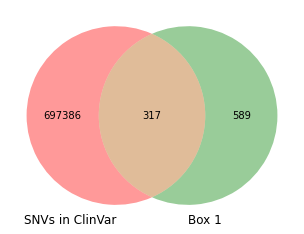

In [163]:
mv.venn2_unweighted(subsets = (len(snvs), len(box), len(box_snvs.uniprot.unique())), set_labels = ('SNVs in ClinVar', 'Box 1'), alpha= 0.4)

In [24]:
box_snvs.origin.value_counts()

germline            26627
unknown               366
germline/somatic      276
somatic               270
not provided          225
not applicable         11
Name: origin, dtype: int64

### Esto de abajo es para generar una sola tabla con todo(dominios, mutaciones, etc..), pero se termina haciendo un quilombo muy grande  
### Mejor dividir en varias tablas

In [ ]:
#Merge con pfam
pfam = box_snv1.merge(pfam_box, on='uniprot')
#Variantes que caen en dominios
pfam['in_dom'] = False
for i in pfam.index:
    if str(pfam.pos[i]) != 'nan':
        if (int(pfam.pos[i]) >= pfam.pfam_start[i]) & (int(pfam.pos[i]) <= pfam.pfam_end[i]):
            pfam.in_dom[i] = True
        else:
            pfam.in_dom[i] = False

pfam = pfam[pfam.in_dom == True]

In [ ]:
#Merge con Low Complexity
lc = box_snv1.merge(lc_box, on='uniprot')
lc['in_lc'] = False
for i in lc.index:
    if str(lc.pos[i]) != 'nan':
        if (int(lc.pos[i]) >= lc.lc_start[i]) & (int(lc.pos[i]) <= lc.lc_end[i]):
            lc.in_lc[i] = True
        else:
            lc.in_lc[i] = False

lc = lc[lc.in_lc == True]


In [ ]:
#Merge con IDRs
idr= box_snv1.merge(idr_box, on='uniprot')
idr['in_idr'] = False
for i in idr.index:
    if str(idr.pos[i]) != 'nan':
        if (int(idr.pos[i]) >= idr.idr_start[i]) & (int(idr.pos[i]) <= idr.idr_end[i]):
            idr.in_idr[i] = True
        else:
            idr.in_idr[i] = False

idr = idr[idr.in_idr == True]

In [ ]:
#MERGE de las tres tablas
df_list = [pfam, lc, idr]
dom_merged = reduce(lambda left, right: pd.merge(left, right, on=['uniprot', 'genesymbol', 'snpid', 'type', 'origin', 'ctrl', 'aa1', 'pos', 'aa2'], how='outer'), df_list)
dom_merged = dom_merged.astype({"pos": np.int64})
dom_merged.to_csv('clivar_snv_dominios.csv', sep=',', index=False)

In [176]:
box_snvs[box_snvs.nuccore_id.isnull()]

,uniprot,organism,mlo,hgnc_id,geneid,genesymbol,snpid,alleleid,type,name,origin,phenotypeids,phenotypelist,otherids,cambio,aa1,pos,aa2,nuccore_id
9728,O14746,Homo sapiens,nucleolus,HGNC:11730,7015.0,TERT,1.554041e+09,47709.0,single nucleotide variant,TERT:c.1710G>Y (p.Lys570Asn),not provided,"MONDO:MONDO:0007485,MedGen:C4551974,OMIM:12755...","Dyskeratosis congenita, autosomal dominant 1",-,(p.Lys570Asn),K,570,N,NaN


In [177]:
len(box_snvs.nuccore_id.unique())
nuccore_list = box_snvs.nuccore_id.unique().tolist()

In [181]:
import urllib
url = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi'

for ids in zip(nuccore_list):
    data = {
        'db': 'nuccore',
        'rettype': 'fasta',
        'genome': ids,
    }
    f = urllib.request.urlopen(url, data)

TypeError: can't concat str to bytes